In [2]:
%matplotlib inline
%load_ext sql

import pandas as pd 
import pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import sklearn
from scipy.stats import mode
import psycopg2 as psy
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sqlalchemy.engine.url import URL
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA 
import matplotlib.patheffects as path_effects

/Users/michael/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/michael/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


# Problem Statement

We were tasked with finding structures in the data provided, and also perhaps factors which help identify lengthy delays for departures and arrivals.

## Fun with psql

In [3]:
# Reading in all the CSV files in from csv files and then preparing them for uploading into psql
cancels = pd.read_csv('../assets/airport_cancellations.csv')
cancels.columns = [c.lower().replace(' ','') for c in cancels.columns] #postgres doesn't like capitals or spaces
ops = pd.read_csv('../assets/Airport_operations.csv')
ops.columns = [c.lower().replace(' ','') for c in ops.columns] #postgres doesn't like capitals or spaces
airports = pd.read_csv('../assets/airports.csv')
airports.columns = [c.lower().replace(' ','') for c in airports.columns] #postgres doesn't like capitals or spaces

In [4]:
# checking the shape of the respective tables
print(cancels.shape)
print(ops.shape)
print(airports.shape)

(805, 6)
(841, 15)
(5167, 13)


In [5]:
# Engine for psql
engine = create_engine('postgresql://@localhost:5432/airports')

In [6]:
%%sql
postgresql://@localhost:5432/airports

u'Connected: @airports'

In [7]:
# pushing the csv data over to psql
airports.to_sql('airports', engine)
ops.to_sql('ops', engine)
cancels.to_sql('cancels', engine)

ValueError: Table 'airports' already exists.

In [8]:
%%sql   
SELECT * FROM ops LIMIT 2

2 rows affected.


[(0L, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (1L, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24)]

In [9]:
%%sql 
SELECT * FROM airports LIMIT 2

2 rows affected.


[(0L, 3443.0, u'STX', u'HENRY E ROHLSEN', u"Henry E Rohlsen Int'l Airport", u'Airport', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', u'Public Use', 17.701556, -64.801722, u'Yes'),
 (1L, 5088.0, u'X64', u'PATILLAS', None, u'Airport', u'ASO', u'#NAME?', u'PATILLAS', u'PR', u'Public Use', 17.982189, -66.01933, u'No')]

In [10]:
%%sql        
SELECT * FROM cancels LIMIT 2

2 rows affected.


[(0L, u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0),
 (1L, u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0)]

In [11]:
%%sql
SELECT * FROM airports a, cancels c WHERE c."airport" = a."locid" LIMIT 2

2 rows affected.


[(10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\ufffdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes', 727L, u'SJU', 2014.0, 280.0, 241.0, 72.0, 31.0),
 (10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\ufffdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes', 726L, u'SJU', 2013.0, 127.0, 94.0, 65.0, 64.0)]

## Done with psql, now going back into python

In [12]:
# mushing the ops and cancels tables into one big df based on airport and year
df = pd.merge(ops, cancels, left_on=['airport', 'year'], right_on=['airport', 'year'], how='outer')

In [13]:
sum(df.airport.value_counts())

847

In [14]:
# Checking the shape of the df
df.shape

(847, 19)

In [15]:
# pinpointing where the nulls are and how many of them there are
df.isnull().sum()

airport                             0
year                                0
departuresformetriccomputation      6
arrivalsformetriccomputation        6
percenton-timegatedepartures        6
percenton-timeairportdepartures     6
percenton-timegatearrivals          6
average_gate_departure_delay        6
average_taxi_out_time               6
averagetaxioutdelay                 6
averageairportdeparturedelay        6
averageairbornedelay                6
averagetaxiindelay                  6
averageblockdelay                   6
averagegatearrivaldelay             6
departurecancellations             42
arrivalcancellations               42
departurediversions                42
arrivaldiversions                  42
dtype: int64

In [16]:
# resetting the df on non-null values in a couple of the columns
df= df[df['departurecancellations'].isnull() != True]
df= df[df['departuresformetriccomputation'].isnull() != True]

In [17]:
# mushing the df we have with the airports df to get one big table
df = pd.merge(df, airports, left_on='airport', right_on ='locid', how='left')

In [18]:
df.shape

(799, 32)

In [19]:
# Checking for nulls 
df.isnull().sum()

airport                            0
year                               0
departuresformetriccomputation     0
arrivalsformetriccomputation       0
percenton-timegatedepartures       0
percenton-timeairportdepartures    0
percenton-timegatearrivals         0
average_gate_departure_delay       0
average_taxi_out_time              0
averagetaxioutdelay                0
averageairportdeparturedelay       0
averageairbornedelay               0
averagetaxiindelay                 0
averageblockdelay                  0
averagegatearrivaldelay            0
departurecancellations             0
arrivalcancellations               0
departurediversions                0
arrivaldiversions                  0
key                                0
locid                              0
ap_name                            0
alias                              0
facilitytype                       0
faaregion                          0
county                             0
city                               0
s

In [20]:
# some data cleaning - getting rid of columns we don't need
del df['key']
del df['locid']
del df['ap_name']
del df['alias']
del df['facilitytype']
del df['boundarydataavailable']

In [21]:
# taking a look at the columns we have remaining
df.columns

Index([u'airport', u'year', u'departuresformetriccomputation',
       u'arrivalsformetriccomputation', u'percenton-timegatedepartures',
       u'percenton-timeairportdepartures', u'percenton-timegatearrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'averagetaxioutdelay', u'averageairportdeparturedelay',
       u'averageairbornedelay', u'averagetaxiindelay', u'averageblockdelay',
       u'averagegatearrivaldelay', u'departurecancellations',
       u'arrivalcancellations', u'departurediversions', u'arrivaldiversions',
       u'faaregion', u'county', u'city', u'state', u'aptype', u'latitude',
       u'longitude'],
      dtype='object')

In [22]:
# renaming the columns into something a bit more easily readable
df.columns = [u'airport', u'year', u'numDepartures',
       u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'FAAregion',
       u'county', u'city', u'state', u'APtype', u'latitude', u'longitude']

In [23]:
# Sub-dataframe for arrival data
a_df = df[[u'airport', u'year',
       u'numArrivals', u'pctOntimeGateArrivals',
       u'avgGateArrivalDelay', u'arrivalCancellations',
       u'arrivalDiversions']]

In [24]:
# Sub-dataframe for departure data
d_df = df[[u'airport', u'year', u'numDepartures',
       u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', 
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay',
       u'departureCancellations',
       u'departureDiversions',]]

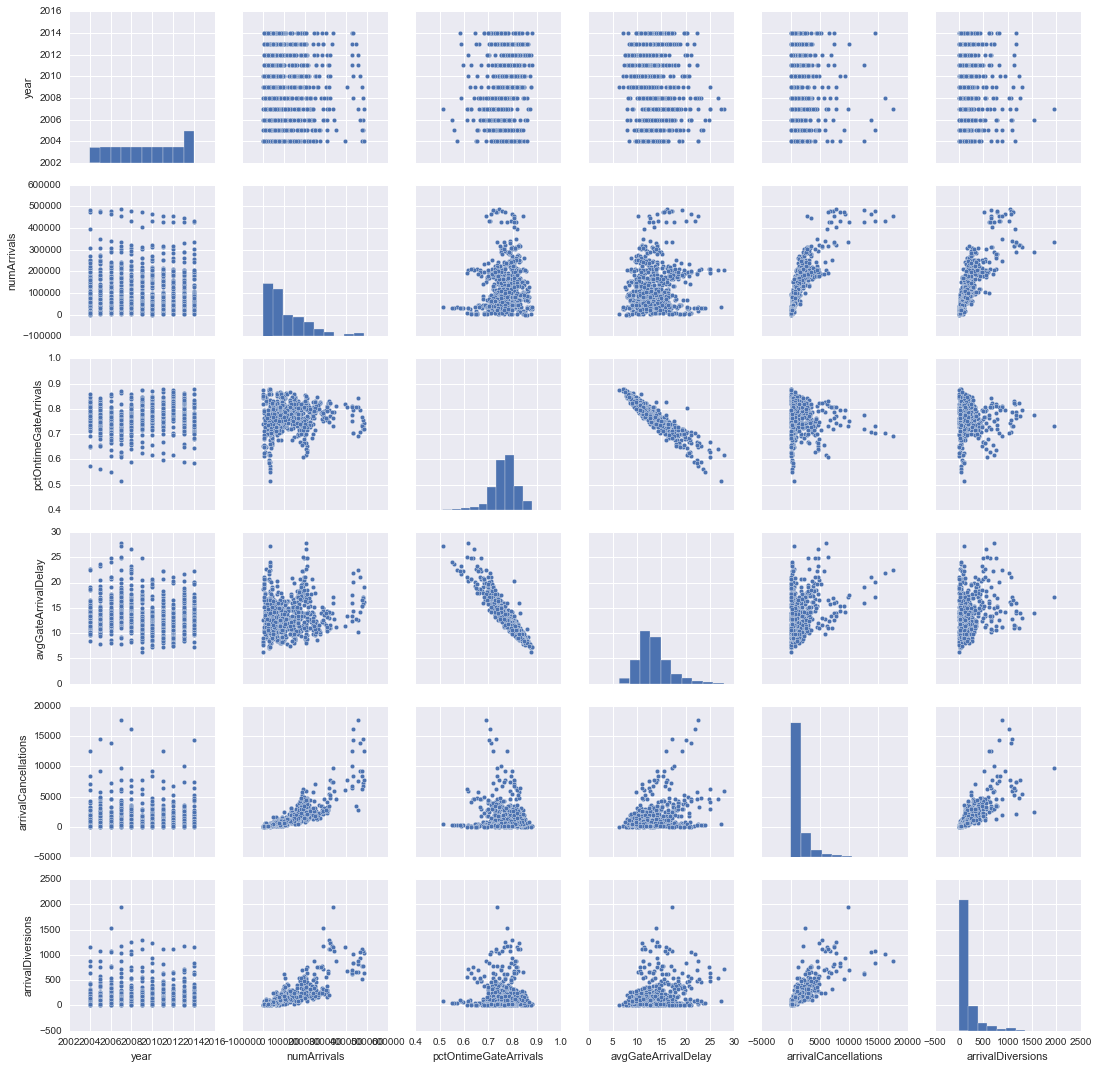

In [25]:
# taking a look at the different variables against each other in the arrivals dataframe, just
# to get a feel for the data, see how it appears to cluster, if there's any correlation, and
# how the distributions look like for the different variables
sns.pairplot(a_df)

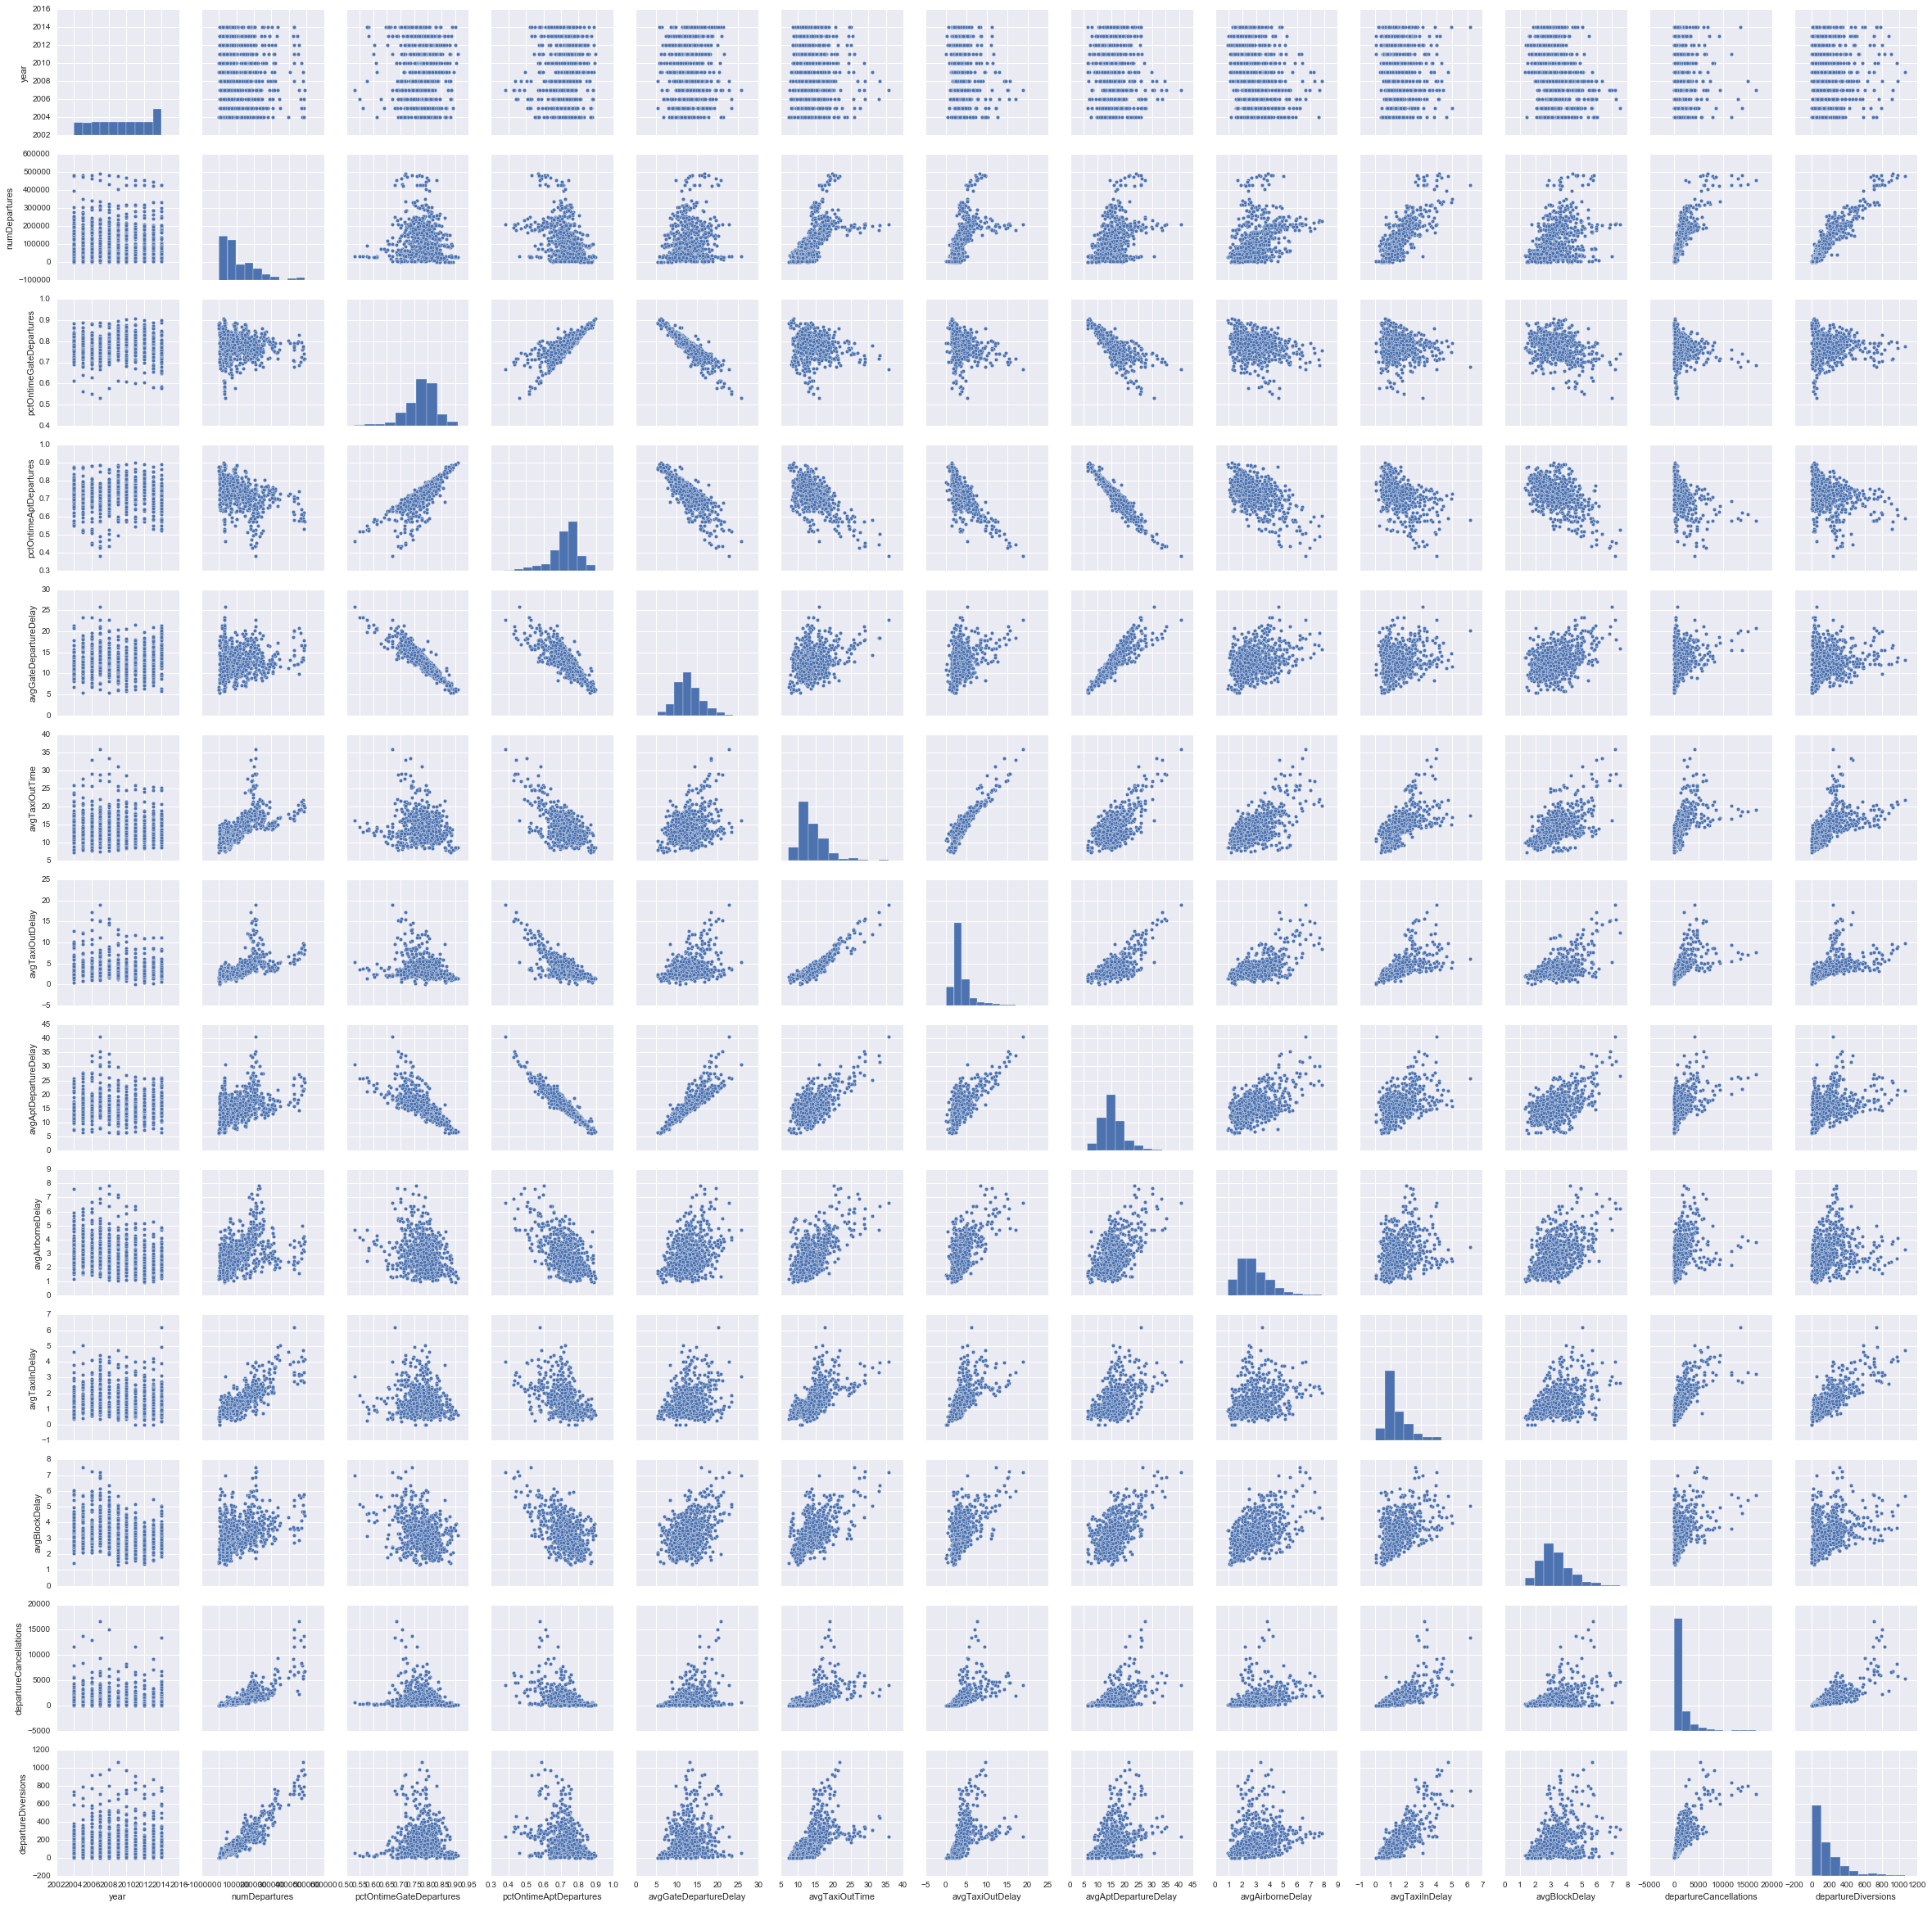

In [26]:
# same as above but this time for the departures dataframe, a bit more in terms of number so 
# graphs are smaller, but we can get an idea for the things listed above 
sns.pairplot(d_df)

## Cleaning and Munging

In [27]:
# A list of cols that we want to keep for analysis, just posting them here so not to get them
# confused with possible dummy columns
cols_to_keep = [u'year', u'numDepartures',
       u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'latitude', u'longitude']

# Creating different dummy df's for the different possible dummy variables.  As we look at 
# things later on, we don't end up really using these dummies as the features count just gets 
# ridiculous and we want to keep things at a simple level (as this is our first PCA foray).
countydf = df[['county']]
countydf = pd.get_dummies(countydf)
countydf.drop('county_#NAME?',1,inplace=True) # for some reason it creates an extra column

statedf = df[['state']]
statedf = pd.get_dummies(statedf)

APtypedf = df[['APtype']]
APtypedf = pd.get_dummies(APtypedf)

FAAdf = df[['FAAregion']]
FAAdf = pd.get_dummies(FAAdf)

In [28]:
# Setting y here, we're doing airport here and label encoding it.  No worries about label 
# encoding as we're using this as a target.  

y = LabelEncoder().fit_transform(df['airport'])
# y = df['airport']

In [29]:
# Creating our "X" for analysis, also scaling them using standardscaler, was thinking of using
# one of the other scaling methods, but didn't think there would be too much of a difference.
# also making it into a dataframe, just for our viewing pleasure
x = df[cols_to_keep]
X = StandardScaler().fit_transform(x.astype(float))
X = pd.DataFrame(X, columns = cols_to_keep)
# Also creating a version of X for PCA analysis later on
Xpca = X.copy()
# Also added the concat portion to include all the dummies to X, but we end up not using them
# as they seem superfluous to the analysis (i.e. no real value added with them)
# X = pd.concat([X, countydf, statedf, APtypedf, FAAdf], axis =1)

In [30]:
# just taking a quick look at our handiwork here, and breathing a sigh of relief taht it looks
# normal(ish).  
X.head(2)

year  numDepartures  numArrivals  pctOntimeGateDepartures  \
0 -1.593401      -0.607163    -0.606139                 0.457014   
1 -1.275754      -0.629020    -0.626018                 0.667555   

   pctOntimeAptDepartures  pctOntimeGateArrivals  avgGateDepartureDelay  \
0                0.709963               0.500021              -0.827217   
1                0.858688               0.658531              -1.084255   

   avgTaxiOutTime  avgTaxiOutDelay  avgAptDepartureDelay  avgAirborneDelay  \
0       -1.047069        -0.536544             -0.826210         -0.355457   
1       -1.073359        -0.596479             -1.032562         -0.526543   

   avgTaxiInDelay  avgBlockDelay  avgGateArrivalDelay  departureCancellations  \
0       -0.683889      -0.749327            -0.787421               -0.574713   
1       -0.613645      -0.961737            -0.981290               -0.586128   

   arrivalCancellations  departureDiversions  arrivalDiversions  latitude  \
0             -0.558841            -0.598447          -0.542560 -0.210788   
1             -0.581577            -0.656408          -0.599323 -0.210788   

   longitude  
0  -0.567524  
1  -0.567524

In [31]:
# Going to look graphically at what number of cluster gives us the best number of clusters 
# using the K Means clustering method.
s = []
i = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    s_i = silhouette_score(X, labels, metric='euclidean')
    s.append(s_i)
    i.append(kmeans.inertia_)

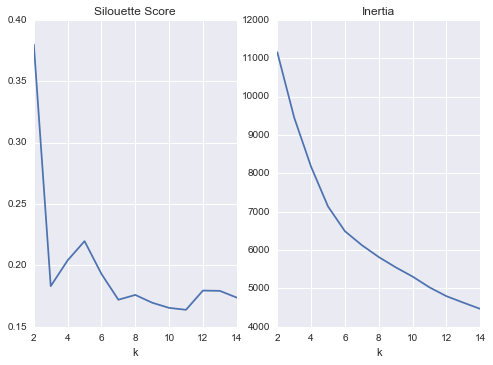

In [32]:
# plotting functions and plotting
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,15), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,15), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

sns.despine()

In [33]:
# After discussing with Alex the tradeoff between silouette score and inertia, the k=5 point 
# looks to be ideal - 2 clusters has a high silouette score, but too high of an inertia score.
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [34]:
# Adding labels to the two dataframes so we can use them to color code our points.
d_df['label']=labels
a_df['label'] = labels

/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [35]:
# checking the columns on the departures dataframe.
d_df.columns

Index([                u'airport',                    u'year',
                 u'numDepartures', u'pctOntimeGateDepartures',
        u'pctOntimeAptDepartures',   u'avgGateDepartureDelay',
                u'avgTaxiOutTime',         u'avgTaxiOutDelay',
          u'avgAptDepartureDelay',        u'avgAirborneDelay',
                u'avgTaxiInDelay',           u'avgBlockDelay',
        u'departureCancellations',     u'departureDiversions',
                         u'label'],
      dtype='object')

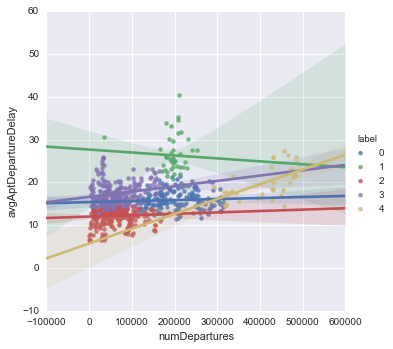

In [36]:
# Seaborn created clusters... which don't look too hot.  
sns.lmplot('numDepartures', 'avgAptDepartureDelay', data=d_df,  hue='label')

In [37]:
a_df.columns

Index([              u'airport',                  u'year',
                 u'numArrivals', u'pctOntimeGateArrivals',
         u'avgGateArrivalDelay',  u'arrivalCancellations',
           u'arrivalDiversions',                 u'label'],
      dtype='object')

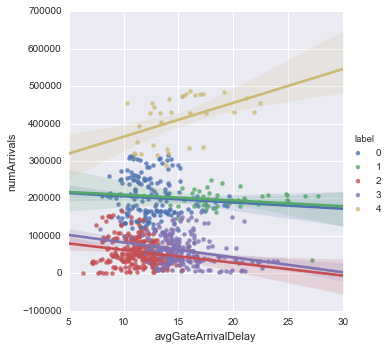

In [38]:
# See comment above on the departure data cluster graphy thing
sns.lmplot('avgGateArrivalDelay', 'numArrivals', data=a_df,  hue='label')

In [39]:
# Silhouette score for the 5 clusters.  Not as great as 2 clusters, but better inertia as we 
# made the point before in deciding 5 clusters over 2.  (The 2 cluster silhouette score is 
# around 0.38 just fyi...)
silhouette_score(X,labels)

0.21982405107907477

In [40]:
k = 5
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

In [41]:
# setting it up to show the centroids, but it's gonna look ugly with 5...
labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

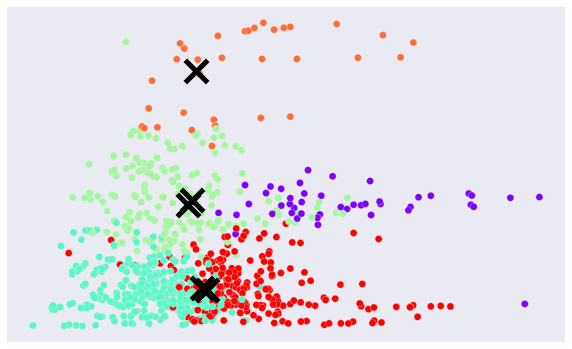

In [42]:
# a plot of 2 features and the 5 centroids.  as we suspected, it ain't pretty.  

fig, ax = plt.subplots(figsize=(10,6))

plt.scatter(X['avgGateArrivalDelay'], X['numArrivals'], c=labels, s=50, cmap='rainbow');
ax.set_xticks([]);
ax.set_yticks([]);

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=500, linewidths=5,
            color='k', zorder=10)

So, the clusters aren't really too distinct, in fact there's a lot of overlap between the clusters.  We can see this simply by the fact that the centroids are pretty much right on top of each other.  Hopefully we can make some more light out of this by taking a look at PCA later down the line.  

## Hierarchical clustering

In [42]:
# Getting the array into a form for the heirarchical clustering model to use.  
Xh = X.as_matrix(columns=None)

In [43]:
# Using complete linkage.  We could use 'ward' or 'single' or 'complete'.  
Z = linkage(Xh, 'complete')

In [44]:
# calculation of c.  which is good.  good to know what c is.  (I googled it.)
c, coph_dists = cophenet(Z, pdist(Xh))
c

0.76162111349590589

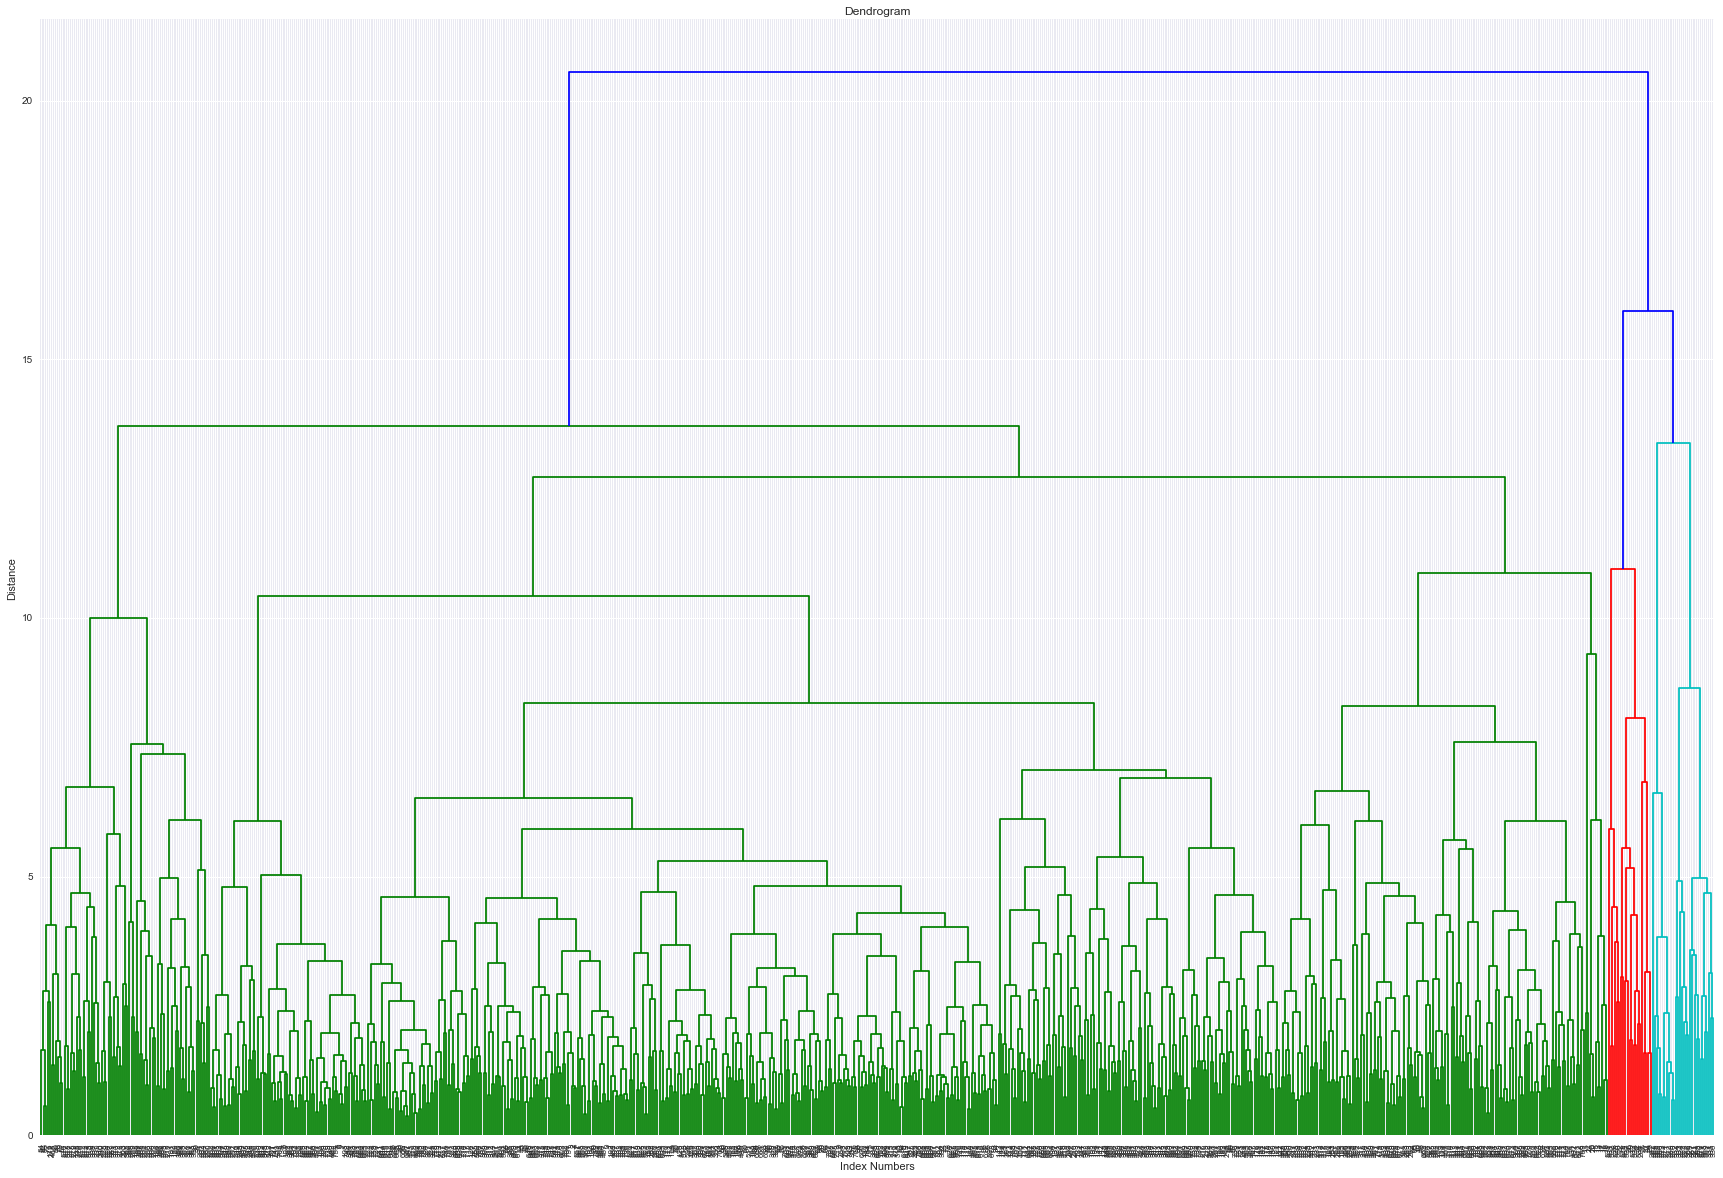

In [45]:
# Yep, kinda crazy as it gets down the dendrogram.
plt.figure(figsize=(30, 20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

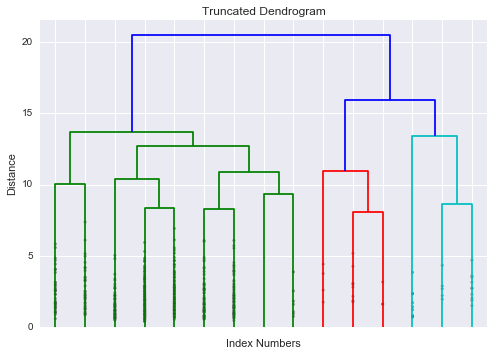

In [46]:
# The very unexciting truncated dendrogram.  Especially after seeing the very exciting full 
# dendrogram. 
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [47]:
# Using a max d number to form our clusters. 
max_d = 14
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [48]:
# Silhouette score for the clusters here... yay.
silhouette_score(X, clusters)

0.47186119751535621

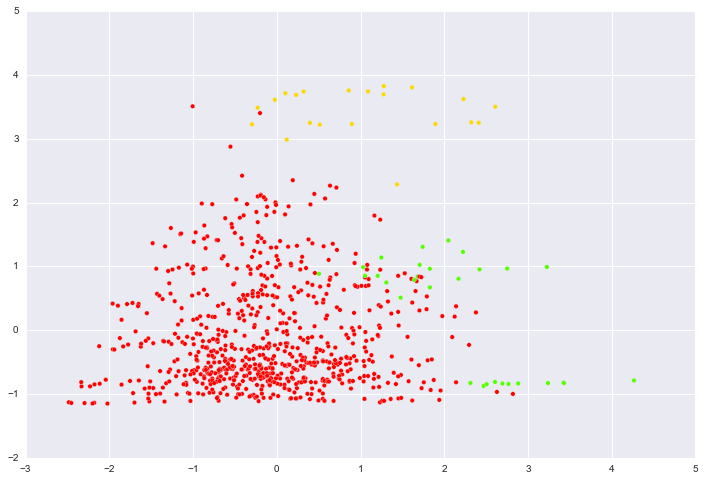

In [49]:
# Another wonderful scattterplot with the clusters.
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X['avgGateDepartureDelay'], X['numArrivals'], c=clusters, cmap='prism', s=20);

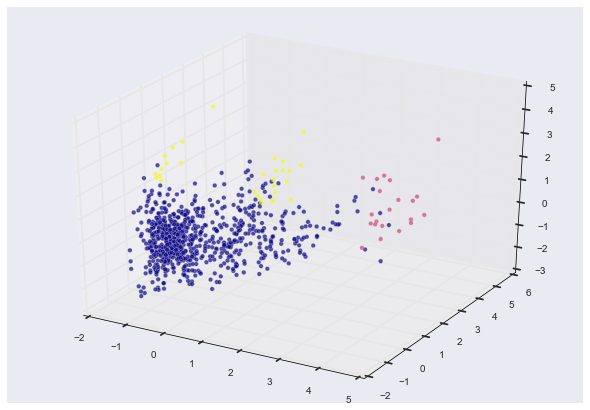

In [50]:
# A nice little 3d scatterplot with some features and coloring based on clusterings
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(X['numArrivals'], X['avgTaxiInDelay'],X['avgGateDepartureDelay'], zdir='z',c=clusters,cmap='plasma', alpha=.7, depthshade=True)
plt.show()

## PCA fun

In [51]:
# took a look at dummifying the following features.  it just blows up the features dataframe
# humungously and doesn't necessarily add a lot of "conciseness"... so, we don't use them. 
# I'll maybe take a look at it tomorrow.  Maybe not.  

# Xpca['airport'] = LabelEncoder().fit_transform(df['airport'])
# Xpca['FAAregion'] = LabelEncoder().fit_transform(df['FAAregion'])
# Xpca['APtype'] = LabelEncoder().fit_transform(df['APtype'])
# Xpca['county'] = LabelEncoder().fit_transform(df['county'])
# Xpca['state'] = LabelEncoder().fit_transform(df['state'])

In [52]:
# just checking the features in the pca features dataframe.  Just checking to see if it's
# kosher or not.  
Xpca.head(1).T

0
year                    -1.593401
numDepartures           -0.607163
numArrivals             -0.606139
pctOntimeGateDepartures  0.457014
pctOntimeAptDepartures   0.709963
pctOntimeGateArrivals    0.500021
avgGateDepartureDelay   -0.827217
avgTaxiOutTime          -1.047069
avgTaxiOutDelay         -0.536544
avgAptDepartureDelay    -0.826210
avgAirborneDelay        -0.355457
avgTaxiInDelay          -0.683889
avgBlockDelay           -0.749327
avgGateArrivalDelay     -0.787421
departureCancellations  -0.574713
arrivalCancellations    -0.558841
departureDiversions     -0.598447
arrivalDiversions       -0.542560
latitude                -0.210788
longitude               -0.567524

In [53]:
# PCA! PCA! PCA! 
Xpca = (Xpca - Xpca.mean())/Xpca.std()
Xpca_corr = np.corrcoef(Xpca.values.T)
eig_vals, eig_vecs = np.linalg.eig(Xpca_corr)

In [54]:
# taking a look the eigenvalues and how they explain the total var.  it looks like using the 
# first three eigenvalues to explain the majority of the var
tot=sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 46.78224876  68.43707195  75.84422331  81.38254894  85.96982638
  89.66555824  92.33277365  94.26809013  95.82502002  97.02726188
  97.91816587  98.73994575  99.34477723  99.6437941   99.89836232
  99.96653075  99.98653184  99.99444408  99.99915691 100.        ]


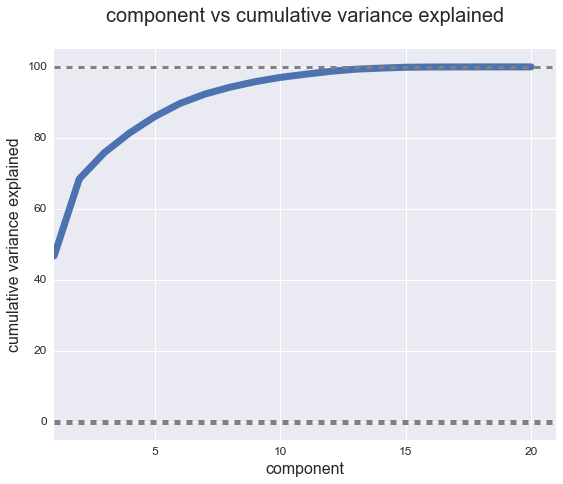

In [55]:
# A graph to show the contribution of explained variance per the eigenvalues just because...
plt.figure(figsize=(9,7))

component_number = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(component_number, cum_var_exp, lw=7)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


ax = plt.gca()
ax.set_xlim([1,21])
ax.set_ylim([-5,105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [56]:
# Just using the first three eigenvalues
PCA_set = PCA(n_components=3)
XPCA = PCA_set.fit_transform(Xpca)
PCdf = pd.DataFrame(XPCA, columns=['PC1','PC2','PC3'])

In [57]:
# PCA! PCA! PCA!
PCdf.head()

PC1       PC2       PC3
0  2.658765 -0.356247  0.999987
1  3.058550 -0.700638  0.814898
2  2.451006 -0.112166  0.366767
3  2.022363  0.062444  0.308438
4  2.606836 -0.326953  0.091743

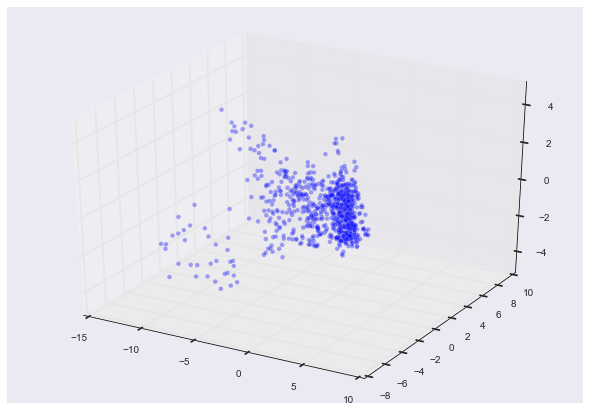

In [58]:
# the pca's graphed against each other.  in different shades of bleu 
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(PCdf['PC1'], PCdf['PC2'], PCdf['PC3'], zdir='z',alpha=.35, depthshade=True, )
plt.show()

In [59]:
# looking at the airports by PCA axes.  and labeling them, once again, just because...
airports2 = df[['airport', 'year']]
airport_pca = airports2.join(PCdf, on=None, how='left')

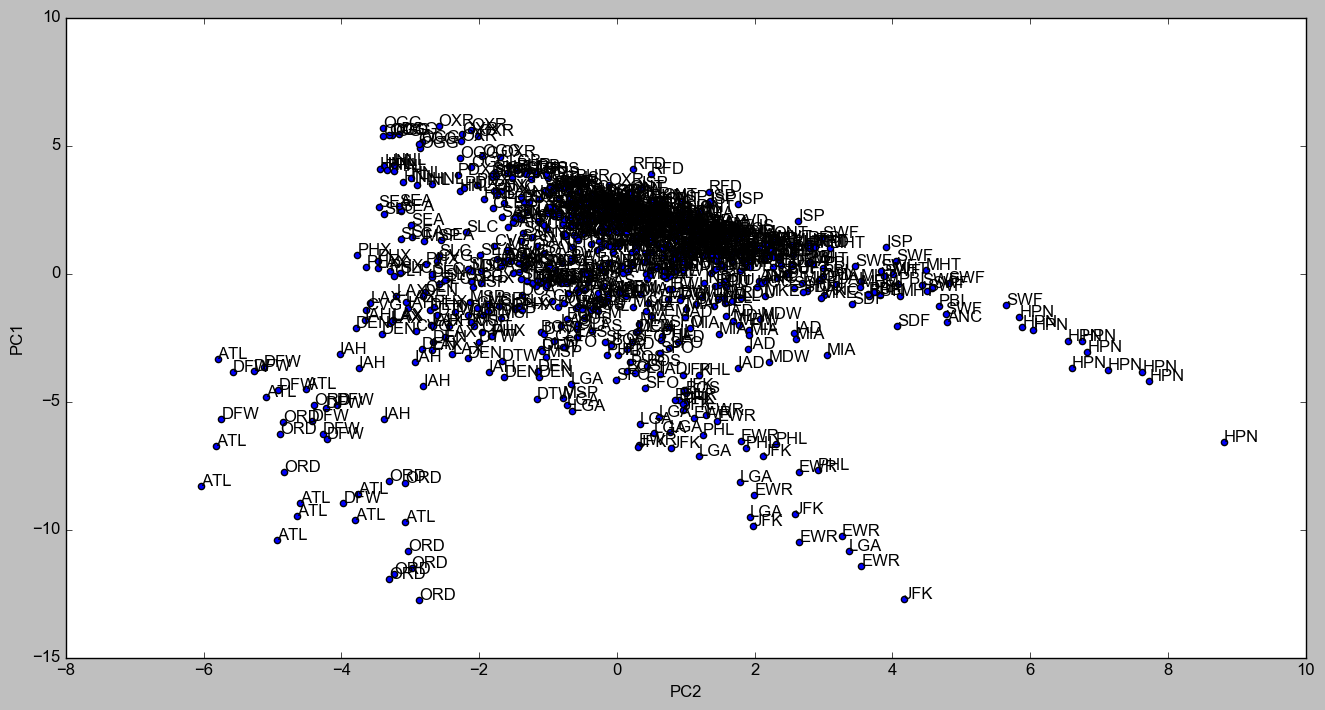

In [60]:
# Looks like one big hairball
matplotlib.style.use('classic')

graph = airport_pca.plot(kind='scatter', x ='PC2', y = 'PC1',figsize=(16,8))

for i, airport in enumerate(df['airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

In [61]:
# Kmeans clustering ensues.  with 5 clusters as per before.  
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit(Xpca)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [62]:
airport_pca['cluster'] = pd.Series(clusters.labels_)

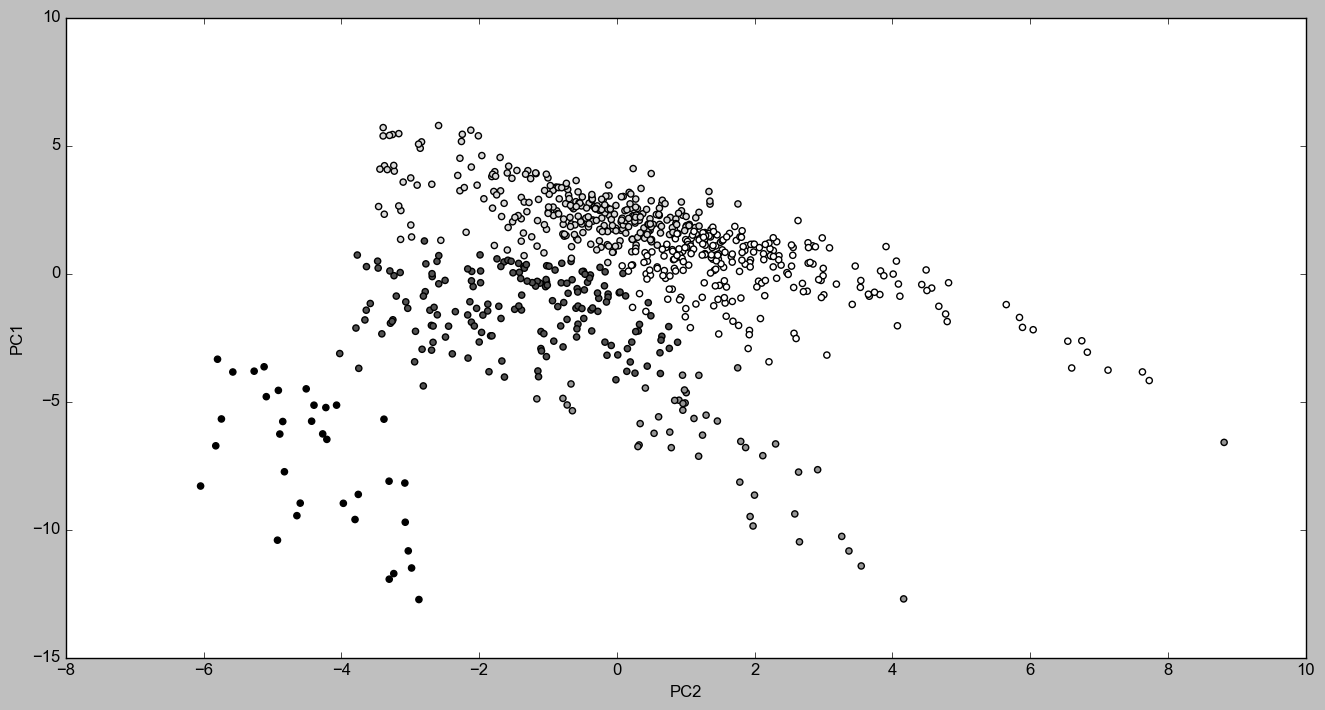

In [63]:
# makes more sense now to use PCA, the clustering looks a bit more sensible
matplotlib.style.use('classic')

graph = airport_pca.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=airport_pca.cluster.astype(np.float), 
    figsize=(16,8))

In [64]:
# Setting up the X_PCS dataframe so i can melt it and then graph everything against the PCA's

X_pcs = X.copy()
X_pcs = (X - X.mean()) / X.std()
X_pcs['PC1'] = PCdf['PC1']
X_pcs['PC2'] = PCdf['PC2']
X_pcs['PC3'] = PCdf['PC3']

In [65]:
# I'm melting... 
X_pcs = pd.melt(X_pcs, id_vars=['PC1','PC2','PC3'])

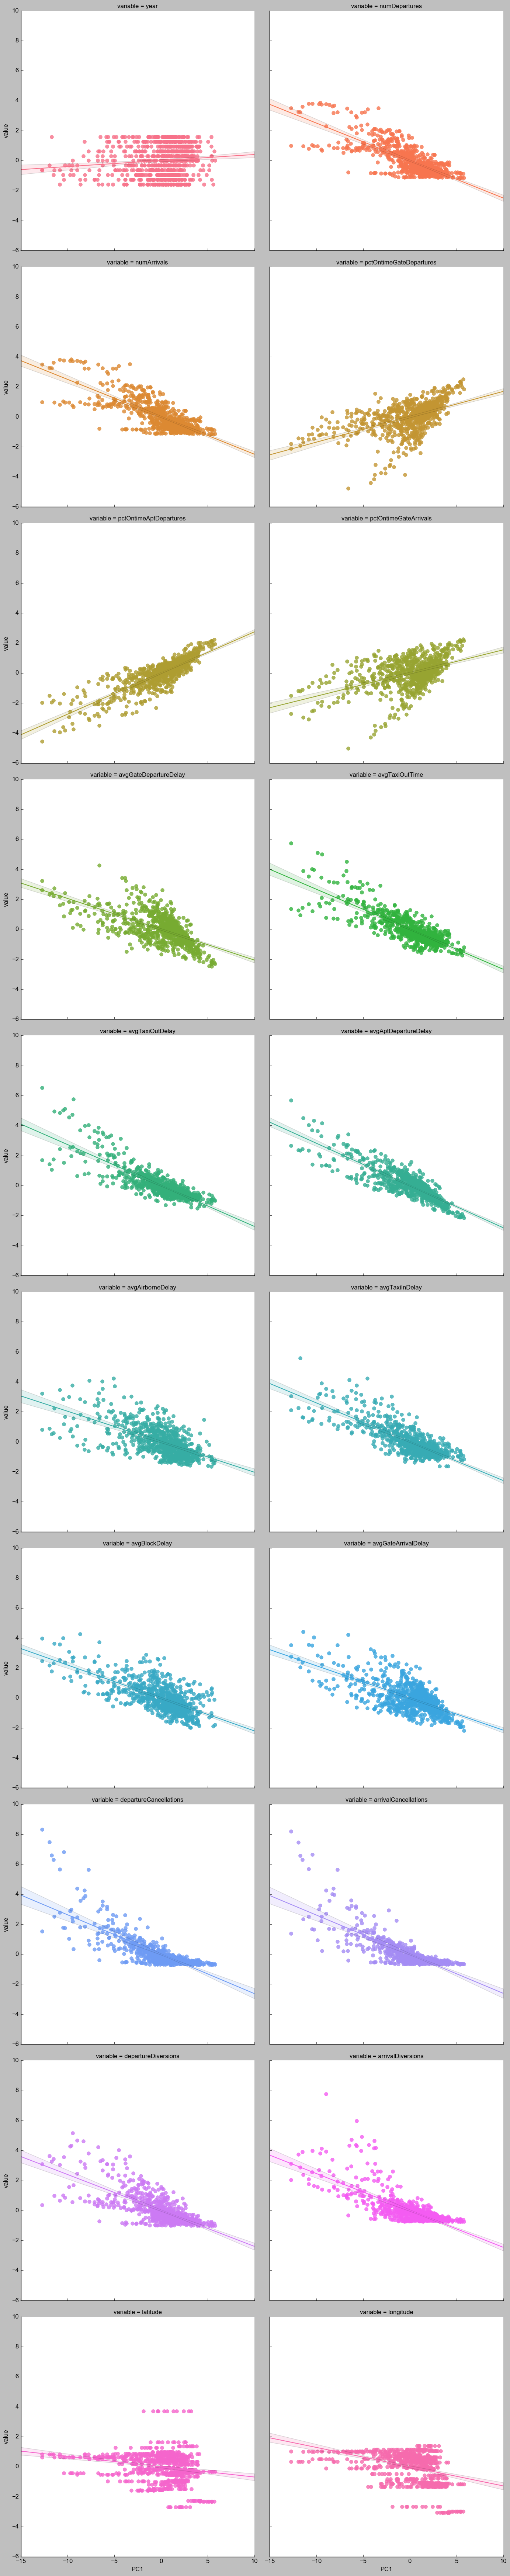

In [66]:
# How PC1 looks against everything
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

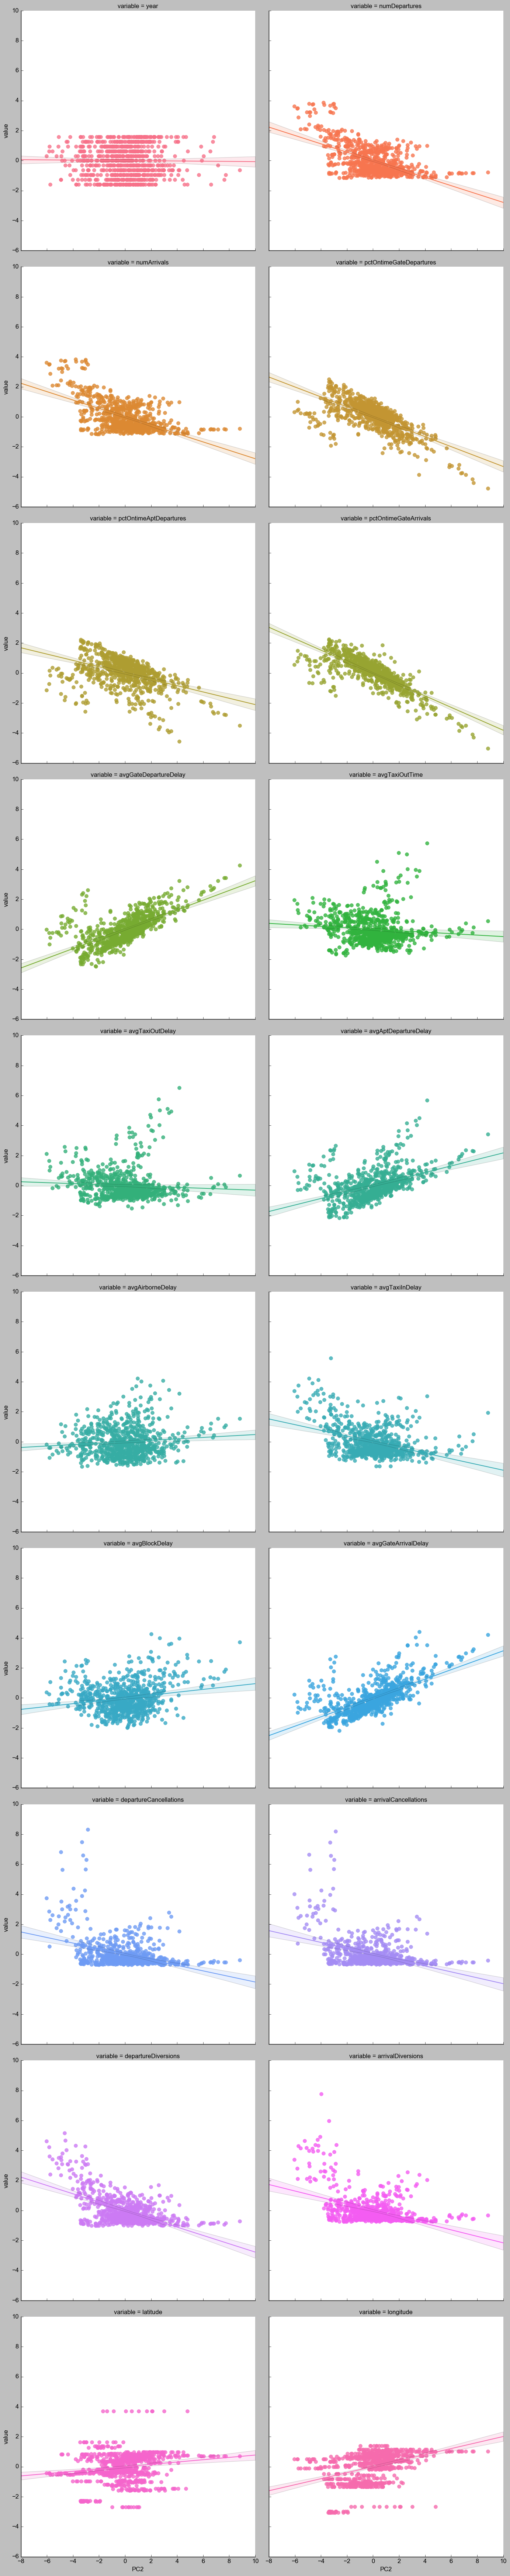

In [67]:
# How PC2 looks against everything
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

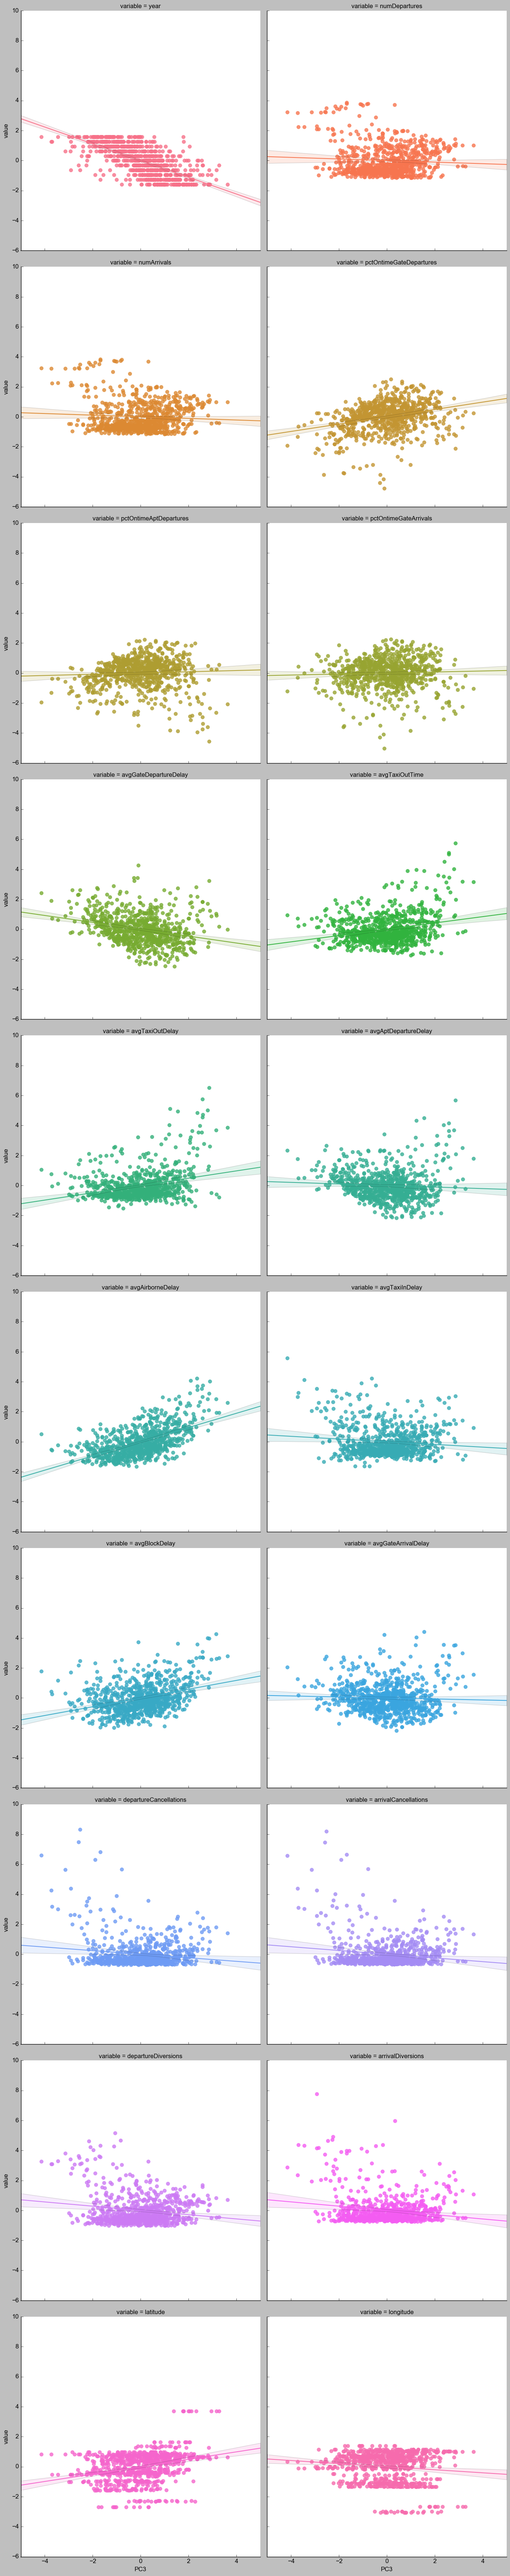

In [68]:
# How PC3 looks against everything
pc3 = sns.lmplot(x="PC3", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

So the graphs of PCA against the features look pretty good.  It appears that PCA is having a positive effect on the separation of the clusters by explaining a lot of the variance.  

## Re-running the clustering analyses with our PCA stuff

In [69]:
s = []
i = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(PCdf)
    labels = kmeans.labels_
    s_i = silhouette_score(PCdf, labels, metric='euclidean')
    s.append(s_i)
    i.append(kmeans.inertia_)

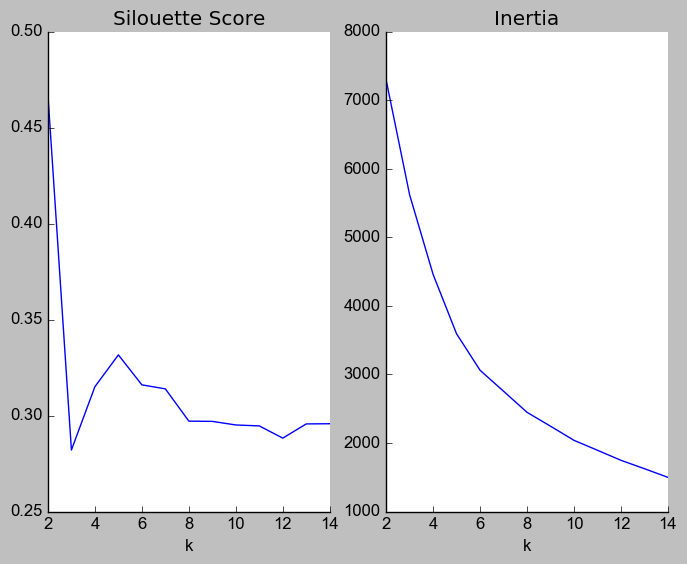

In [70]:
# Again, we choose 5 clusters even though 2 clusters has a higher silhouette score.  but 
# in tandem with the inertia score, 5 clusters looks like the way to go.
matplotlib.style.use('classic')

f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,15), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,15), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

sns.despine()

In [71]:
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(PCdf)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [72]:
PCdf['label']=labels

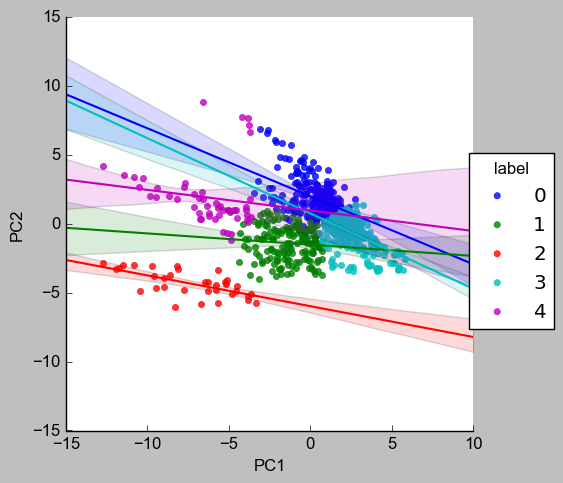

In [73]:
# plotting it out.. still a bit of a mess, but maybe slightly better?  
sns.lmplot('PC1', 'PC2', data=PCdf,  hue='label')

In [74]:
# Definitely a better silhouette score than the pre-PCA version. Better than double the previous.
silhouette_score(PCdf,labels)

0.445084684081194

## Hierarchical clustering with PCA

In [75]:
Xhpca =PCdf.as_matrix(columns=None)

In [76]:
Z = linkage(Xhpca, 'complete')

In [77]:
# yay, we calculated c
c, coph_dists = cophenet(Z, pdist(Xhpca))
c

0.7744291527458852

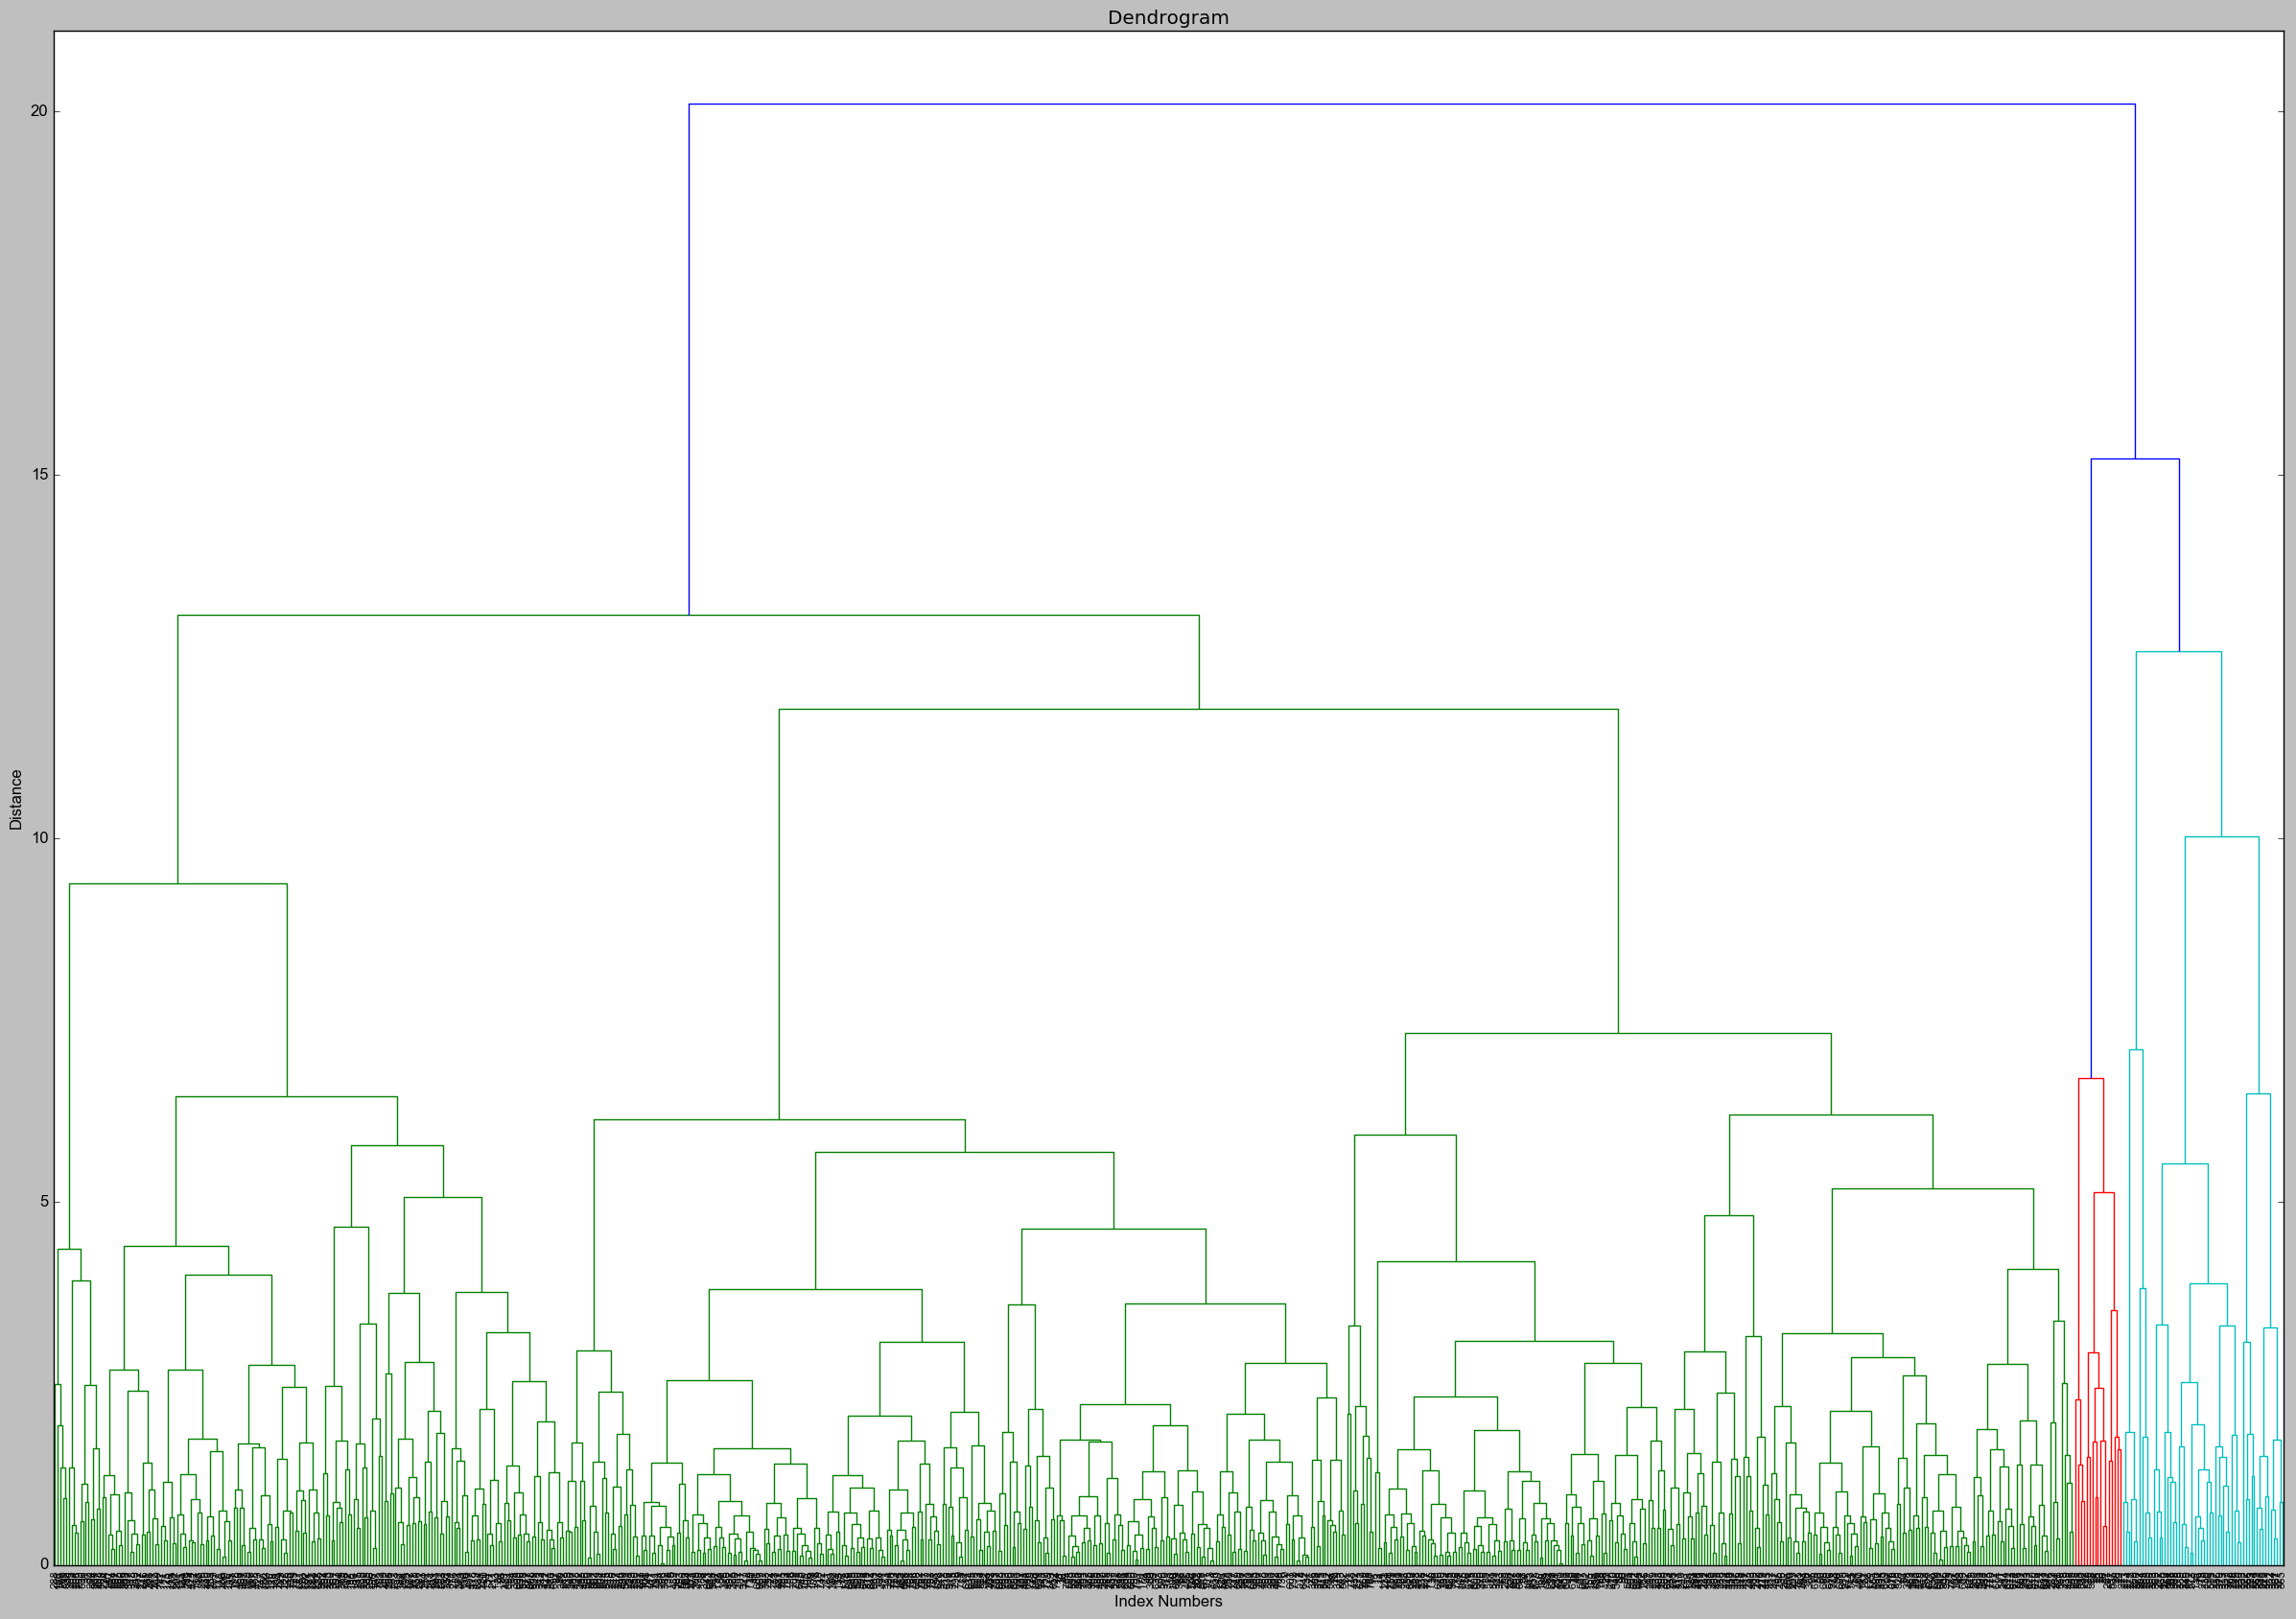

In [78]:
# another tree.  but this time done PCA
plt.figure(figsize=(30, 20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

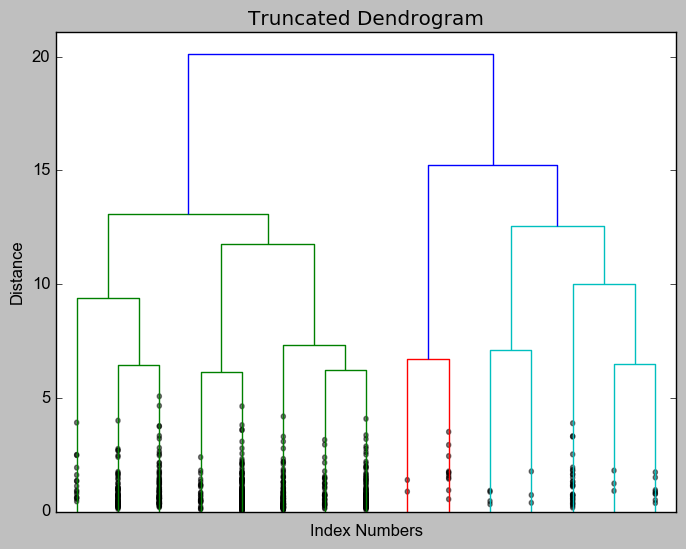

In [79]:
# truncated like before
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [80]:
# using the same max d as before, and showing the clusters
max_d = 14
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [81]:
# hmm not as good as before... 
silhouette_score(PCdf, clusters)

0.48576731320928146

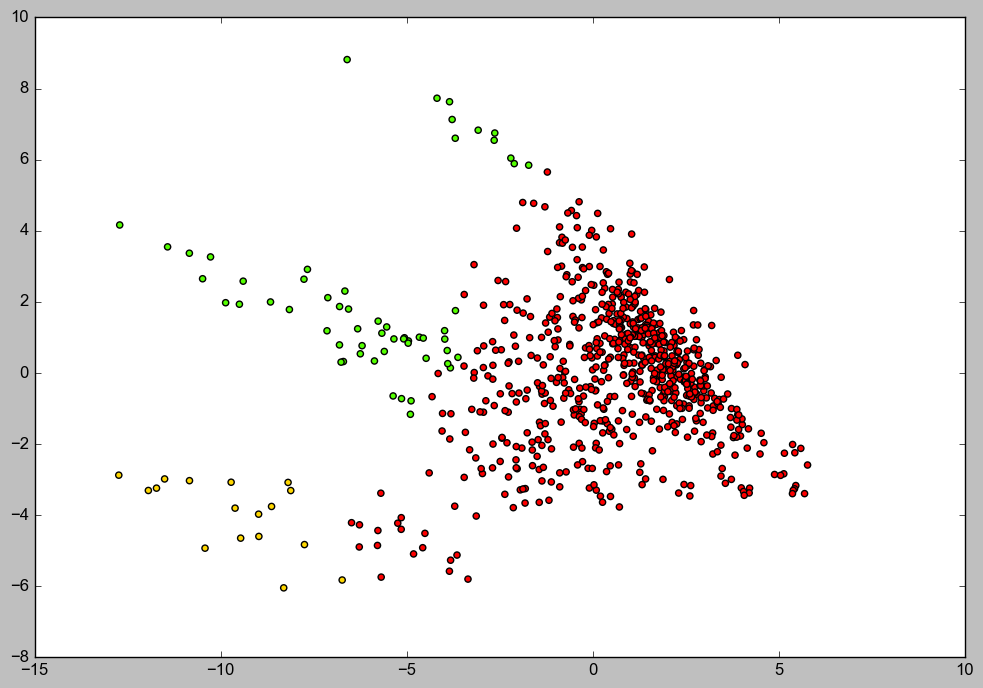

In [82]:
# PCA1 vs PCA2.  Looks okay... 
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(PCdf['PC1'], PCdf['PC2'], c=clusters, cmap='prism', s=20);

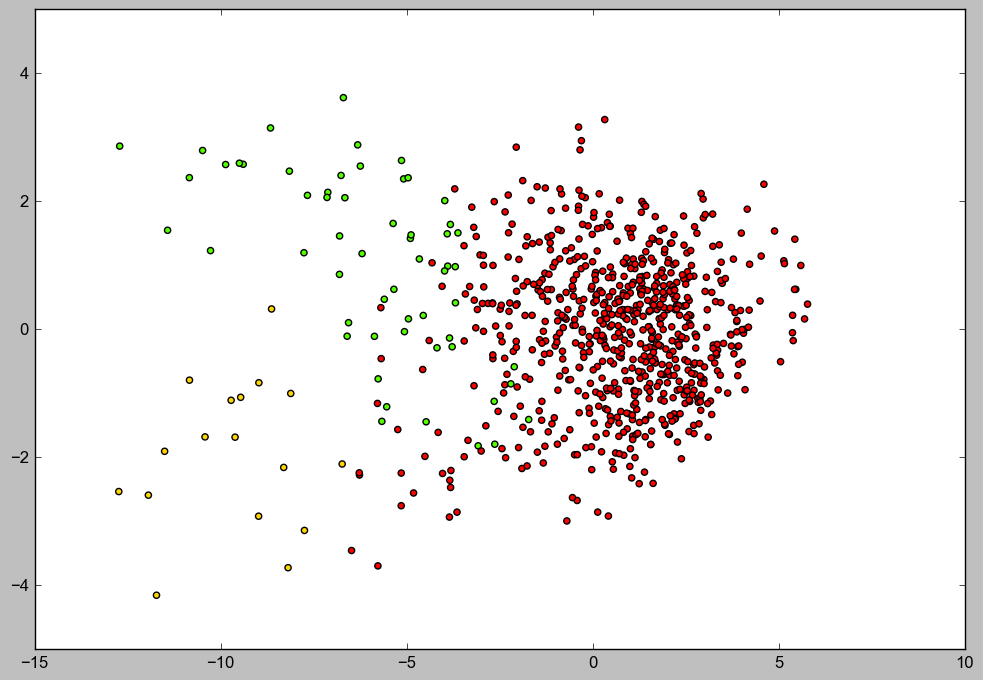

In [83]:
# PCA1 vs PCA3, looks okay... i guess

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(PCdf['PC1'], PCdf['PC3'], c=clusters, cmap='prism', s=20);

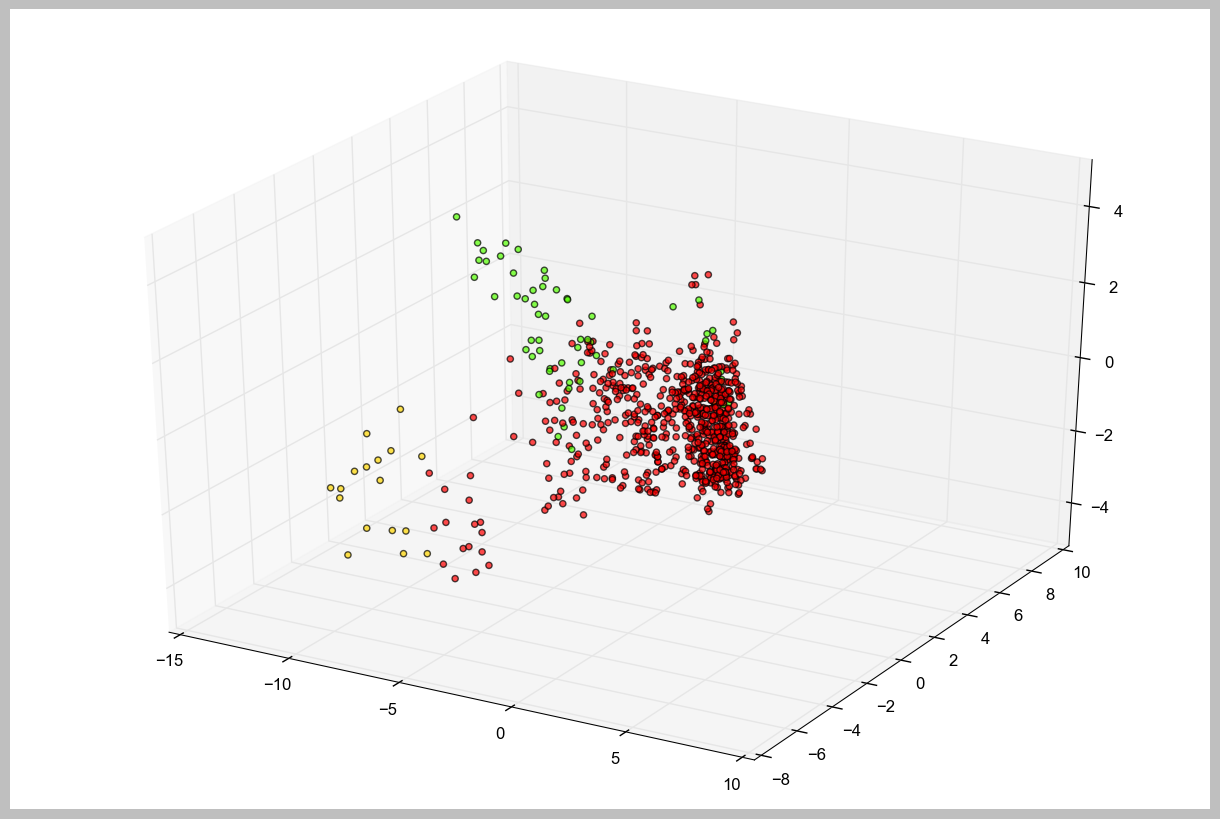

In [84]:
# A nice little 3d graph
fig = pylab.figure(figsize=(12,8))
ax = Axes3D(fig)
ax.scatter(PCdf['PC1'], PCdf['PC2'],PCdf['PC3'], zdir='z',c=clusters,cmap='prism', alpha=.7, depthshade=True)
plt.show()

So from here, we're going to take a look at logistic regression, random forest classifiers to predict some things...

## Logistic Regression analysis 

In [85]:
# seeing if we can predict FAA region through logistic regression
LR1df = X
LR1df.drop('latitude',1,inplace=True)
LR1df.drop('longitude',1,inplace=True)
y = LabelEncoder().fit_transform(df['FAAregion'])

In [86]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve 
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for long/short delays', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')

def plot_confusion_matrix(cm, title='Confusion matrix', labels= [1,2,3], cmap=plt.cm.Blues, t_number =2):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(t_number)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

In [87]:
# train test splitting it up
X_train, X_test, y_train, y_test = train_test_split(LR1df.values,y,test_size = 0.33,  random_state = 77)

In [88]:
# and now putting it in the logistic regression model
logreg = LogisticRegression(random_state = 77)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

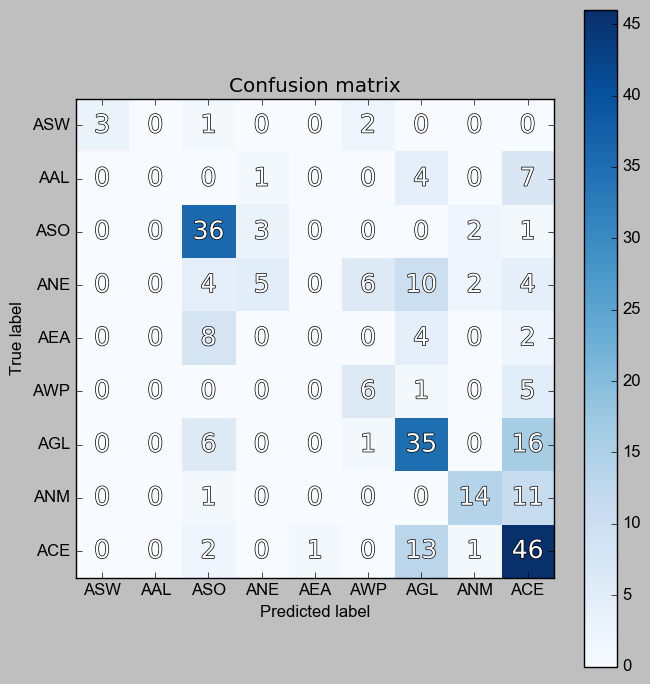

In [89]:
# confusion matrix fun
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [90]:
# Accuracy tells us the percent of FAA regions correctly predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying FAA regions
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified FAA regions
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.549242424242
precision score: 0.511543901284
recall score: 0.549242424242


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass o

## Random Forest classifier 

In [91]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

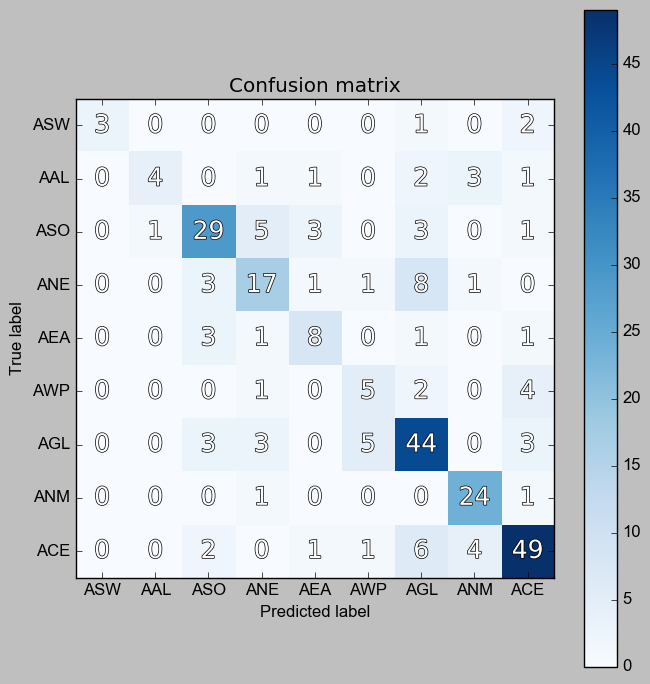

In [92]:
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [93]:
# Accuracy tells us the percent of FAA regions correctly predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying FAA regions
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified FAA regions
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.693181818182
precision score: 0.699251093229
recall score: 0.693181818182


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [94]:
ranfor.feature_importances_

array([ 0.02143524,  0.05731156,  0.06767778,  0.03589214,  0.05638157,
        0.04718589,  0.03811356,  0.10780324,  0.04912321,  0.04930229,
        0.06769234,  0.02873524,  0.05458404,  0.0734465 ,  0.04812877,
        0.05070434,  0.07520824,  0.07127403])

In [95]:
# As expected
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
avgTaxiOutTime               0.107803
departureDiversions          0.075208
avgGateArrivalDelay          0.073447
arrivalDiversions            0.071274
avgAirborneDelay             0.067692
numArrivals                  0.067678
numDepartures                0.057312
pctOntimeAptDepartures       0.056382
avgBlockDelay                0.054584
arrivalCancellations         0.050704

In [96]:
LR1df.columns

Index([u'year', u'numDepartures', u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime', u'avgTaxiOutDelay',
       u'avgAptDepartureDelay', u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay', u'departureCancellations',
       u'arrivalCancellations', u'departureDiversions', u'arrivalDiversions'],
      dtype='object')

## Looking to predict long/short delays this time rather than FAA regions

In [97]:
# Changing our 'y' to reflect the new target
y = df['avgAptDepartureDelay'].apply(lambda x: 1 if x > np.median(df['avgAptDepartureDelay']) else 0)

In [98]:
LR1df.columns

Index([u'year', u'numDepartures', u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime', u'avgTaxiOutDelay',
       u'avgAptDepartureDelay', u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay', u'departureCancellations',
       u'arrivalCancellations', u'departureDiversions', u'arrivalDiversions'],
      dtype='object')

In [99]:
LR1df.drop('avgAptDepartureDelay',1,inplace=True)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(LR1df, y, test_size = 0.3, random_state = 77, stratify = y)

In [101]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

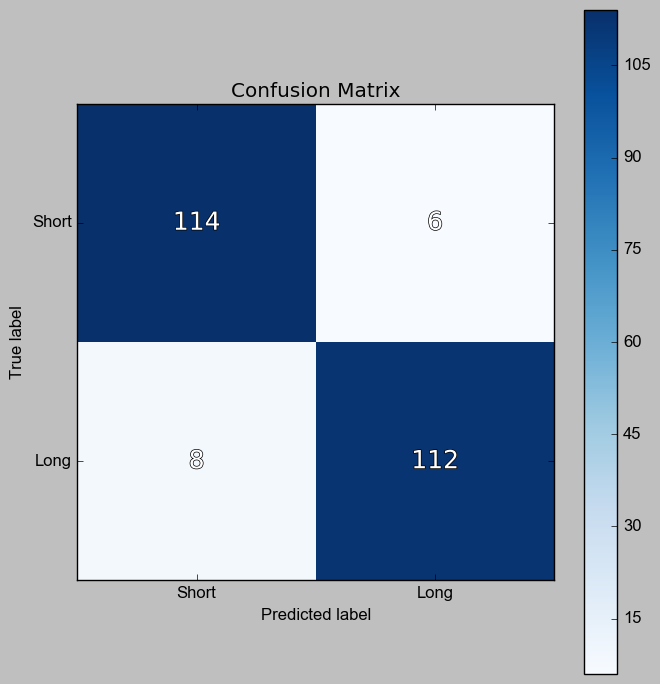

In [102]:
# A good looking confusion matrix
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat, labels = ['Short','Long'], title = 'Confusion Matrix')

In [103]:
print classification_report(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.93      0.95      0.94       120
          1       0.95      0.93      0.94       120

avg / total       0.94      0.94      0.94       240



In [104]:
# Accuracy tells us the percent of long/short delays predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying length of delays
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified long/short delays
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.941666666667
precision score: 0.949152542373
recall score: 0.933333333333


In [105]:
# As expected
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
avgGateDepartureDelay         0.431941
pctOntimeAptDepartures        0.232480
pctOntimeGateDepartures       0.078025
avgGateArrivalDelay           0.071783
avgTaxiOutTime                0.041978
pctOntimeGateArrivals         0.029144
departureCancellations        0.027889
avgBlockDelay                 0.018226
avgTaxiOutDelay               0.015043
avgAirborneDelay              0.013359

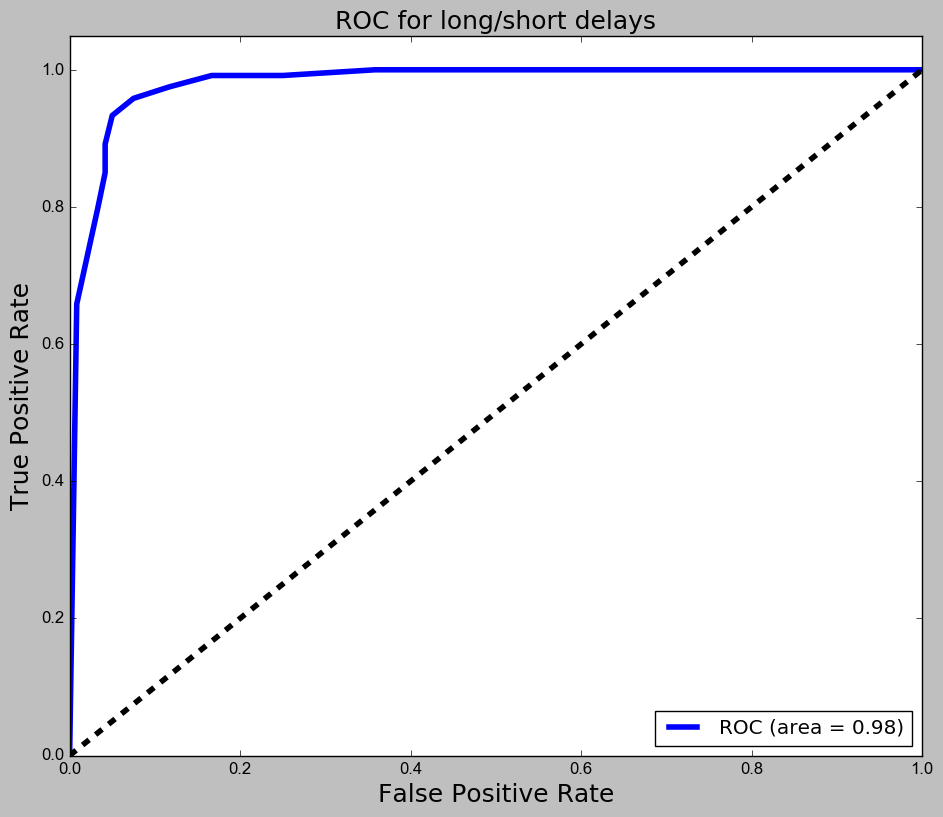

In [106]:
# decent looking curve
y_score = ranfor.predict_proba(X_test).T[1]
plot_roc(y_test, y_score)

## Logistic Regression analysis with PCA features included

In [110]:
# seeing if we can predict FAA region using the PCA df through logistic regression
LRdf = PCdf
LRdf.drop('label',1,inplace=True)
y = LabelEncoder().fit_transform(df['FAAregion'])

In [111]:
# train test splitting it up
X_train, X_test, y_train, y_test = train_test_split(LRdf.values,y,test_size = 0.33,  random_state = 77)

In [112]:
# and now putting it in the logistic regression model
logreg = LogisticRegression(random_state = 77)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

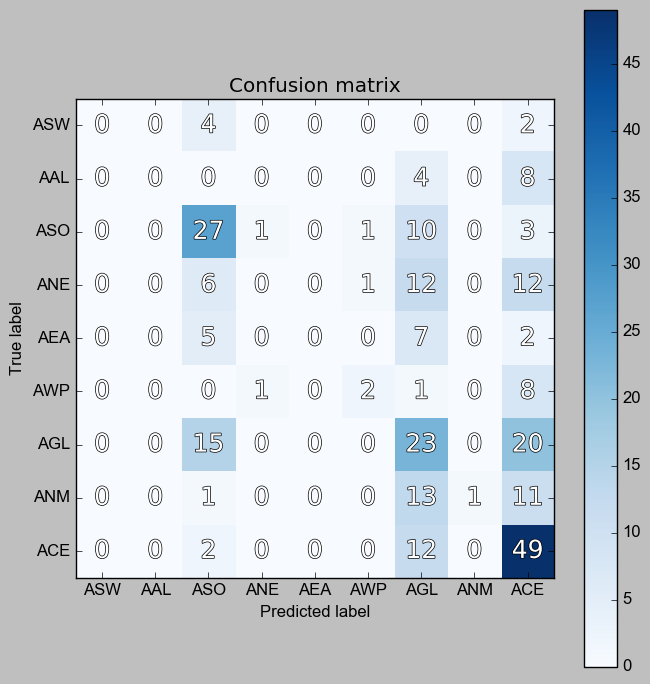

In [113]:
# confusion matrix fun
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [114]:
# Accuracy tells us the percent of FAA regions correctly predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying FAA regions
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified FAA regions
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.386363636364
precision score: 0.356105192969
recall score: 0.386363636364


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

## Random Forest classifier 

In [115]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

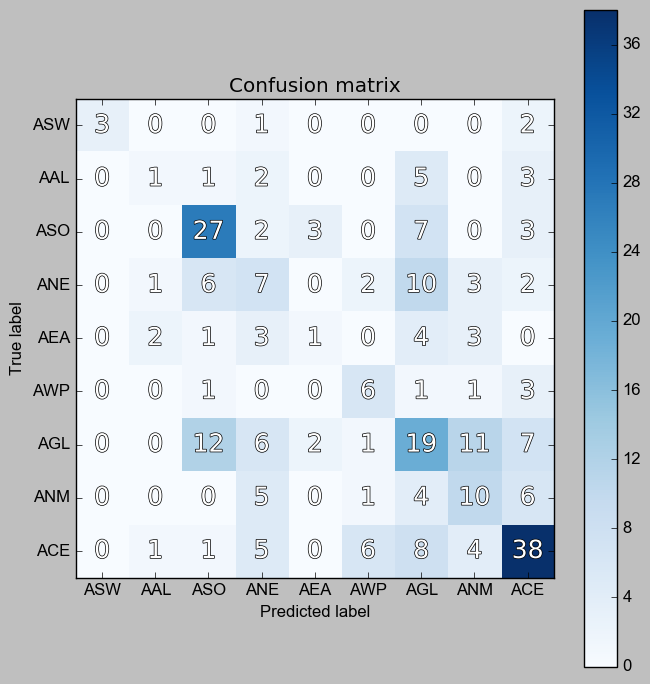

In [116]:
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [117]:
# Accuracy tells us the percent of FAA regions correctly predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying FAA regions
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified FAA regions
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.424242424242
precision score: 0.41631606241
recall score: 0.424242424242


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [118]:
ranfor.feature_importances_

array([ 0.38434544,  0.32816992,  0.28748464])

In [120]:
# As expected
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=LRdf.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
PC1       0.384345
PC2       0.328170
PC3       0.287485

In [122]:
LRdf.columns

Index([u'PC1', u'PC2', u'PC3'], dtype='object')

## Looking to predict long/short delays this time rather than FAA regions

In [123]:
# Changing our 'y' to reflect the new target
y = df['avgAptDepartureDelay'].apply(lambda x: 1 if x > np.median(df['avgAptDepartureDelay']) else 0)

In [125]:
LRdf.columns

Index([u'PC1', u'PC2', u'PC3'], dtype='object')

In [126]:
X_train, X_test, y_train, y_test = train_test_split(LRdf, y, test_size = 0.3, random_state = 77, stratify = y)

In [127]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

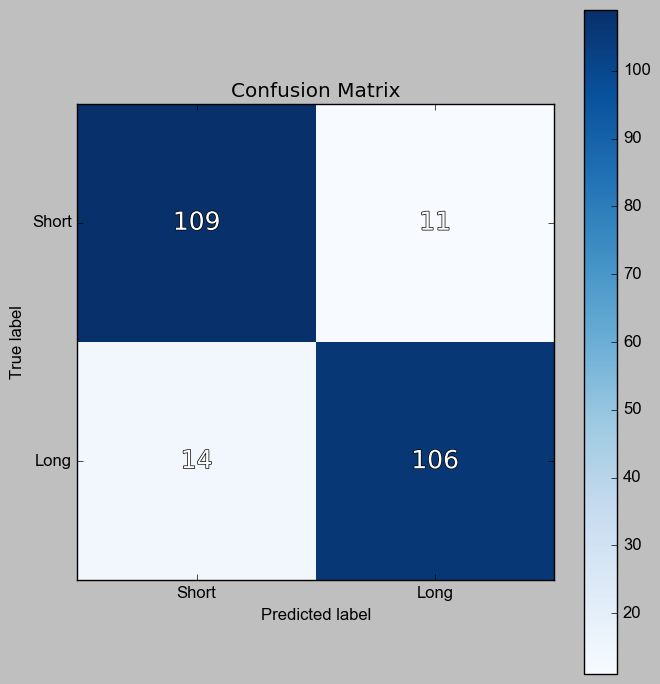

In [128]:
# A good looking confusion matrix
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat, labels = ['Short','Long'], title = 'Confusion Matrix')

In [129]:
print classification_report(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.89      0.91      0.90       120
          1       0.91      0.88      0.89       120

avg / total       0.90      0.90      0.90       240



In [130]:
# Accuracy tells us the percent of long/short delays predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying length of delays
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified long/short delays
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.895833333333
precision score: 0.905982905983
recall score: 0.883333333333


In [132]:
# As expected
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=LRdf.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
PC1       0.606066
PC2       0.263625
PC3       0.130309

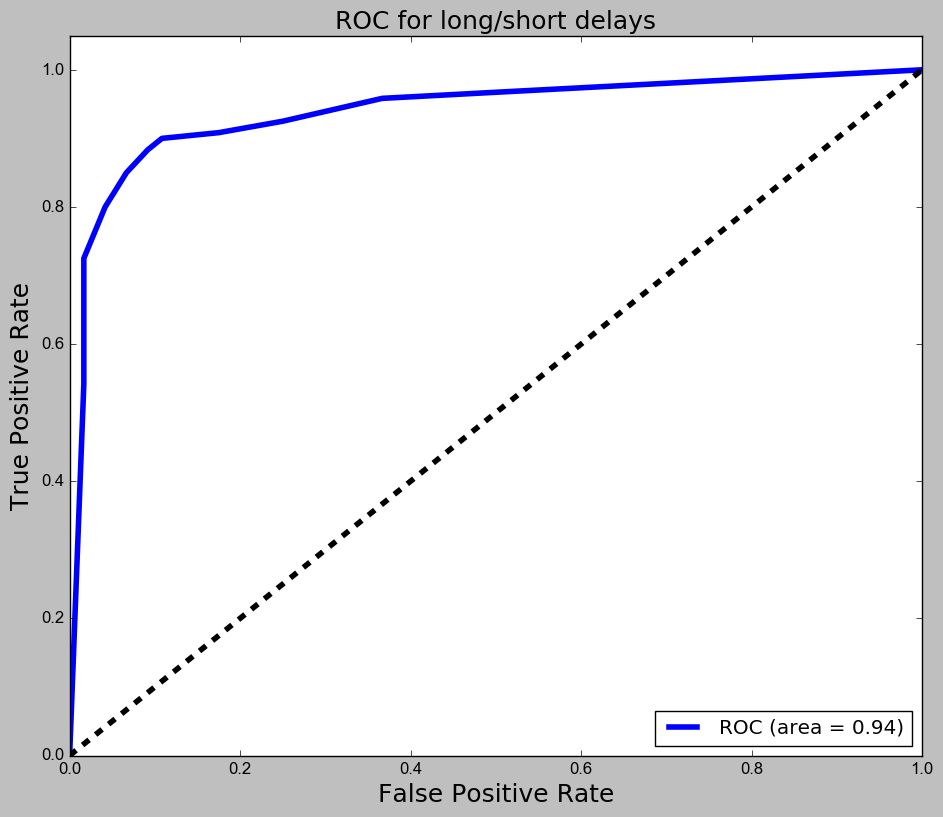

In [133]:
# decent looking curve
y_score = ranfor.predict_proba(X_test).T[1]
plot_roc(y_test, y_score)

So we also did a blog post.  Not something we're particularly proud of as most bloggers seem to be an insufferable sort, but you have to do what you have to do.

http://changmichael.github.io/no_small_furry_animals_were_harmed/

In [141]:
df.columns

Index([u'airport', u'year', u'numDepartures', u'numArrivals',
       u'pctOntimeGateDepartures', u'pctOntimeAptDepartures',
       u'pctOntimeGateArrivals', u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay', u'avgAirborneDelay',
       u'avgTaxiInDelay', u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'FAAregion', u'county',
       u'city', u'state', u'APtype', u'latitude', u'longitude'],
      dtype='object')

In [144]:
latedf =  df.sort(['avgAptDepartureDelay'], ascending=False)

/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [146]:
latedf['airport']

333    JFK
223    EWR
224    EWR
332    JFK
366    LGA
222    EWR
334    JFK
267    HPN
571    PHL
367    LGA
225    EWR
331    JFK
365    LGA
570    PHL
569    PHL
531    ORD
336    JFK
221    EWR
530    ORD
370    LGA
268    HPN
532    ORD
373    LGA
538    ORD
528    ORD
372    LGA
265    HPN
228    EWR
266    HPN
229    EWR
      ... 
104    BUR
708    SJC
565    PDX
687    SEA
247    HNL
689    SEA
379    LGB
250    HNL
688    SEA
248    HNL
245    HNL
249    HNL
504    OGG
498    OGG
542    OXR
252    HNL
496    OGG
244    HNL
495    OGG
539    OXR
503    OGG
500    OGG
497    OGG
502    OGG
543    OXR
501    OGG
545    OXR
540    OXR
505    OGG
544    OXR
Name: airport, dtype: object